# `make_circles` dataset

In [1]:
import logitboost_j_implementation as logitboost
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss


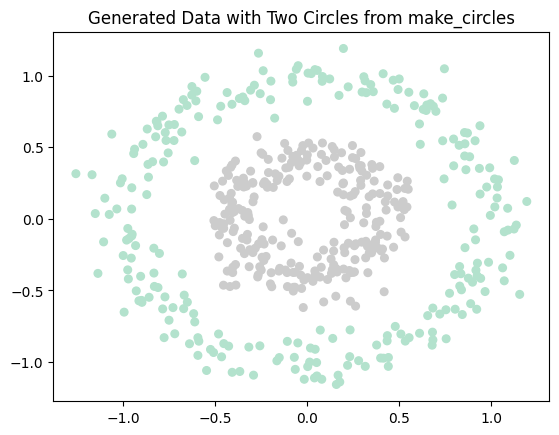

Shape of X2: (500, 2)
Shape of y2: (500,)


In [2]:
# Generate synthetic data using make_circles
X, y = make_circles(n_samples=500, noise=0.1, factor=0.4, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.Pastel2)    
plt.title("Generated Data with Two Circles from make_circles")
plt.show()

print("Shape of X2:", X.shape)
print("Shape of y2:", y.shape)

In [3]:
# Adding the third term to the dataset
# X1^2 + X2^2
X_ext = np.hstack((X, (np.sum(X**2, axis=1).reshape(-1, 1))))
X_ext

array([[-0.69705539,  0.76525651,  1.07150375],
       [ 0.20435243,  0.05902255,  0.04524357],
       [ 0.32252223,  0.30384746,  0.19634386],
       ...,
       [-1.25759097,  0.31488338,  1.68068658],
       [ 0.3208562 ,  0.88023071,  0.8777548 ],
       [-0.3666217 , -1.06563321,  1.26998561]])

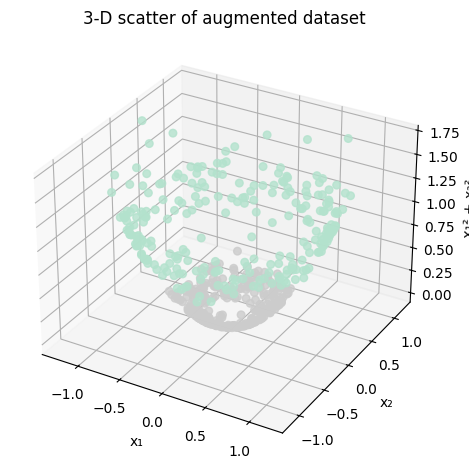

In [4]:
from mpl_toolkits.mplot3d import Axes3D          # registers the 3-D projection

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# X_ext  → shape (n_samples, 3)
# y      → 1-D array of class labels you got from make_blobs
ax.scatter(X_ext[:, 0], X_ext[:, 1], X_ext[:, 2], c=y, alpha=0.8, cmap=plt.cm.Pastel2, s=30)

ax.set_xlabel("x₁")
ax.set_ylabel("x₂")
ax.set_zlabel("x₁² + x₂²")
plt.title("3-D scatter of augmented dataset")
plt.tight_layout()
plt.show()


In [5]:
# Split the dataset into training and testing sets
# For original data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# For extended data
X_train_ext, X_test_ext, y_train_ext, y_test_ext = train_test_split(X_ext, y, test_size=0.3, random_state=42)

## LogitBoost for *J* classes algorithm

### For original dataset

In [6]:
# Fit the LogitBoost model
learners1, J1 = logitboost.logitboost_fit(X_train, y_train, n_estimators=500)

# Predict using the fitted model on test set
y_pred1 = logitboost.logitboost_predict(X_test, learners1, J1)
y_proba1 = logitboost.logitboost_predict_proba(X_test, learners1, J1)

# Evaluate the model
acc1 = accuracy_score(y_test, y_pred1)
roc1 = roc_auc_score(y_test, y_proba1[:, 1])
log_loss1 = log_loss(y_test, y_proba1)

# Print results for original make_circles
print(f"Log-loss on original make_circles: {log_loss1:.4f}")
print(f"Accuracy on original make_circles: {acc1:.4f}")
print(f"ROC AUC on original make_circles: {roc1:.4f}")

Log-loss on original make_circles: 0.6935
Accuracy on original make_circles: 0.6133
ROC AUC on original make_circles: 0.5188


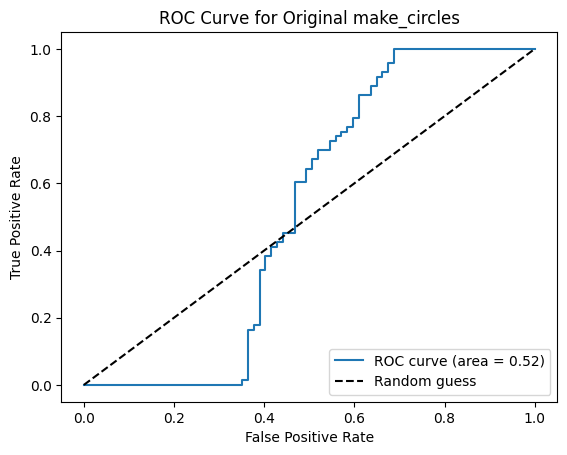

In [7]:
# Visualizations
# ROC curve for original make_circles
from sklearn.metrics import roc_curve
fpr1, tpr1, _ = roc_curve(y_test, y_proba1[:, 1])
plt.figure()
plt.plot(fpr1, tpr1, label='ROC curve (area = {:.2f})'.format(roc1))
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Original make_circles')
plt.legend(loc='lower right')
plt.show()

In [8]:
# Visualize the class predictions
def plot_decision_boundary(
        X, y, learners, J,
        title="Decision boundary",
        fill_value="mean",       # cómo rellenar las dimensiones extra: "mean" | "median" | float
        h=0.01                   # paso de la rejilla
    ):
    """
    X : array (n_samples, D)         Datos completos.
    y : array (n_samples,)           Etiquetas de 0 … J-1.
    J : int                          Número de clases.
    learners : objeto(s) del modelo  Pasan a logitboost_predict.
    title : str                      Título de la figura.
    fill_value : str | float         Cómo rellenar dims 3…D para la rejilla.
    h : float                        Resolución de la rejilla.
    """

    # --- 1. Preparar rejilla en las primeras dos dimensiones -----------------
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # --- 2. Construir matriz completa para el predictor -----------------------
    n_grid = xx.size
    X_grid = np.zeros((n_grid, 2))
    X_grid[:, 0] = xx.ravel()
    X_grid[:, 1] = yy.ravel()

    if X.shape[1] > 2:
        X_grid = np.hstack((X_grid, (np.sum(X_grid**2, axis=1).reshape(-1, 1))))

    # --- 3. Predicción --------------------------------------------------------
    Z = logitboost.logitboost_predict(X_grid, learners, J=J)   # (n_grid,) con etiquetas 0…J-1
    Z = Z.reshape(xx.shape)

    # --- 4. Dibujar -----------------------------------------------------------
    # 4.1 Puntos de entrenamiento
    plt.figure(figsize=(8, 6))
    J = len(np.unique(y))

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Pastel2,
                s=30, edgecolors='k')

    # 4.2 Frontera de decisión
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Pastel2)

    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.tight_layout()
    plt.show()

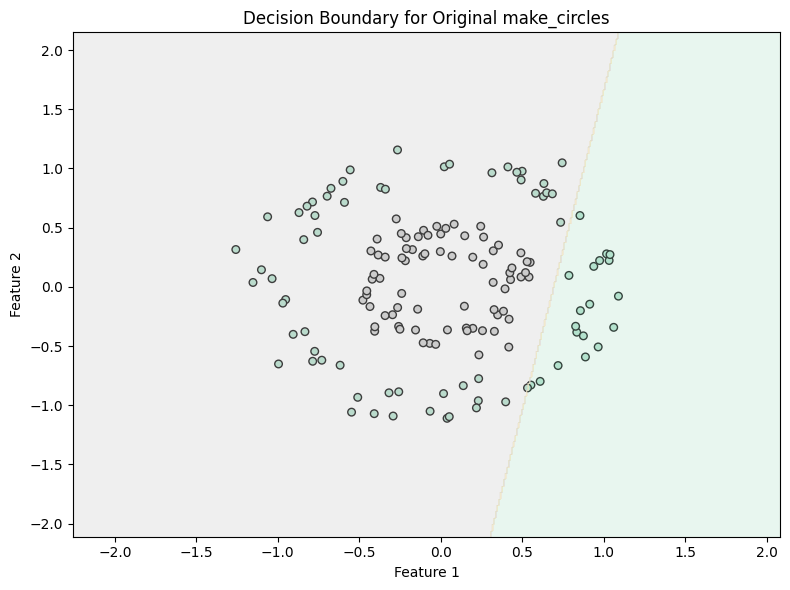

In [9]:
plot_decision_boundary(X_test, y_test, learners1, J1,
                       title="Decision Boundary for Original make_circles",)

### For extended dataset

In [10]:
# Fit the LogitBoost model
learners2, J2 = logitboost.logitboost_fit(X_train_ext, y_train_ext, n_estimators=500)

# Predict using the fitted model on test set
y_pred2 = logitboost.logitboost_predict(X_test_ext, learners2, J2)
y_proba2 = logitboost.logitboost_predict_proba(X_test_ext, learners2, J2)

# Evaluate the model
acc2 = accuracy_score(y_test_ext, y_pred2)
log_loss2 = log_loss(y_test_ext, y_proba2)
roc2 = roc_auc_score(y_test_ext, y_proba2[:, 1])

# Print results for extended make_circles
print(f"Log-loss on extended make_circles: {log_loss2:.4f}")
print(f"Accuracy on extended make_circles: {acc2:.4f}")
print(f"ROC AUC on extended make_circles: {roc2:.4f}")

Log-loss on extended make_circles: 0.0000
Accuracy on extended make_circles: 1.0000
ROC AUC on extended make_circles: 1.0000


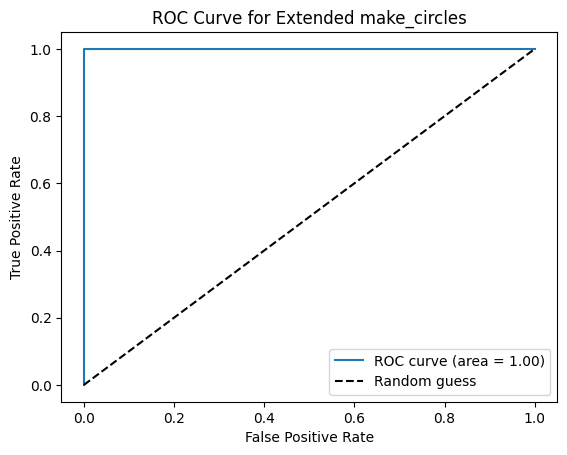

In [11]:
fpr2, tpr2, _ = roc_curve(y_test_ext, y_proba2[:, 1])
plt.figure()
plt.plot(fpr2, tpr2, label='ROC curve (area = {:.2f})'.format(roc2))
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Extended make_circles')
plt.legend(loc='lower right')
plt.show()

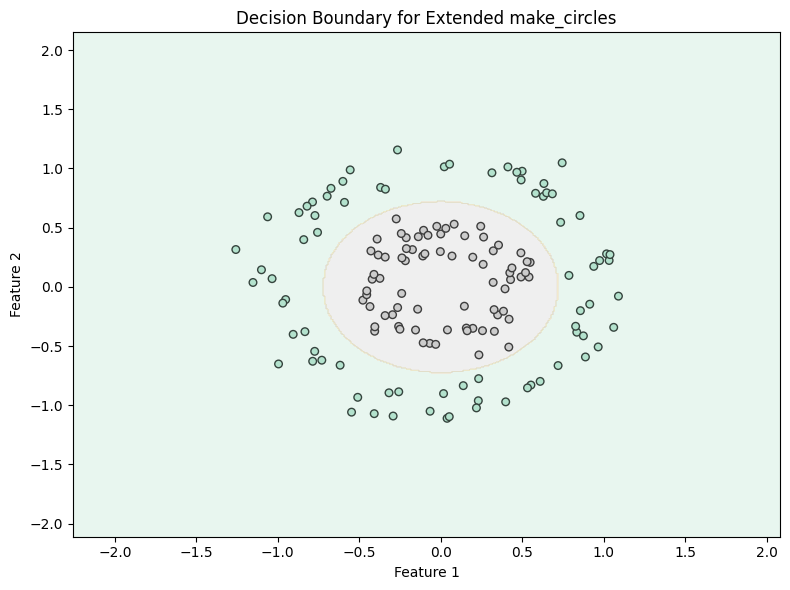

In [12]:
plot_decision_boundary(X_test_ext, y_test_ext, learners2, J2, title="Decision Boundary for Extended make_circles")

### Calibration with *LogitBoost* for $J$ classes model

#### Calibration Curve
Calibration curves, also referred to as reliability diagrams, compare how well the probabilistic predictions of a binary classifier are calibrated. It plots the frequency of the positive label (to be more precise, an estimation of the conditional event probability $P(Y=1 | \text{predict proba})$ ) on the y-axis against the predicted probability predict_proba of a model on the x-axis. The tricky part is to get values for the y-axis.

In [13]:
# ------------------------------------------------------------
# 1.  Get class-probability estimates for each model
# ------------------------------------------------------------
#  -> keep only the probability of the positive class (column 1)
proba_orig = logitboost.logitboost_predict_proba(X_test,     learners1, J1)[:, 1]
proba_ext  = logitboost.logitboost_predict_proba(X_test_ext, learners2, J2)[:, 1]

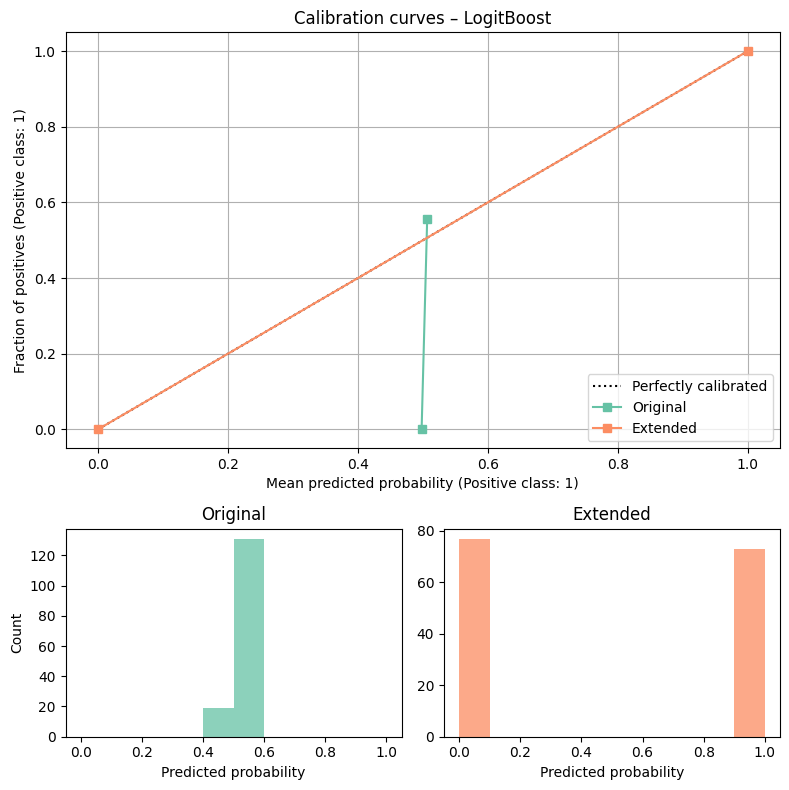

In [14]:
# ------------------------------------------------------------
# 2.  Draw calibration plots
# ------------------------------------------------------------
from sklearn.calibration import CalibrationDisplay
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(8, 8))
gs  = GridSpec(nrows=2, ncols=2, height_ratios=[2, 1])

ax_curve = fig.add_subplot(gs[0, :])                 # big panel for the curves
ax_hist1 = fig.add_subplot(gs[1, 0])                 # histogram – model 1
ax_hist2 = fig.add_subplot(gs[1, 1])                 # histogram – model 2
colors   = plt.get_cmap("Set2")

# ―― Curve for the ORIGINAL data ――
CalibrationDisplay.from_predictions(
    y_test,           # true labels (binary, 0 / 1)
    proba_orig,       # predicted prob of class 1
    n_bins=10,
    name="Original",
    ax=ax_curve,
    color=colors(0),
)

# ―― Curve for the EXTENDED data ――
CalibrationDisplay.from_predictions(
    y_test_ext,
    proba_ext,
    n_bins=10,
    name="Extended",
    ax=ax_curve,
    color=colors(1),
)

ax_curve.set_title("Calibration curves – LogitBoost")
ax_curve.grid(True)

# ------------------------------------------------------------
# 3.  Add probability histograms (optional but informative)
# ------------------------------------------------------------
ax_hist1.hist(proba_orig, bins=10, range=(0, 1),
              color=colors(0), alpha=0.75)
ax_hist1.set(title="Original", xlabel="Predicted probability", ylabel="Count")

ax_hist2.hist(proba_ext,  bins=10, range=(0, 1),
              color=colors(1), alpha=0.75)
ax_hist2.set(title="Extended", xlabel="Predicted probability")

fig.tight_layout()
plt.show()


In [15]:
from collections import defaultdict
import pandas as pd
from sklearn.metrics import (
    brier_score_loss, log_loss, roc_auc_score,
    precision_score, recall_score, f1_score
)

models = [
    ("LogitBoost (original)", learners1, J1, X_test,     y_test),
    ("LogitBoost (extended)", learners2, J2, X_test_ext, y_test_ext),
]


# Gather all metrics in a dictionary
scores = defaultdict(list)

for name, learners, J, X_te, y_te in models:
    # Probability estimates of the positive class (column 1)
    y_prob = logitboost.logitboost_predict_proba(X_te, learners, J)[:, 1]
    # Hard predictions (labels)
    y_pred = logitboost.logitboost_predict(X_te, learners, J)
    
    scores["Classifier"].append(name)
    
    # Metrics that use probabilities
    for metric in (brier_score_loss, log_loss, roc_auc_score):
        col = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[col].append(metric(y_te, y_prob))
    
    # Metrics that use hard predictions
    for metric in (precision_score, recall_score, f1_score):
        col = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[col].append(metric(y_te, y_pred))


score_df = (
    pd.DataFrame(scores)
      .set_index("Classifier")
      .round(3)
      .sort_index()
)

print(score_df)


                       Brier  loss  Log loss  Roc auc   Precision   Recall   \
Classifier                                                                    
LogitBoost (extended)         0.00     0.000     1.000       1.000      1.0   
LogitBoost (original)         0.25     0.693     0.519       0.557      1.0   

                         F1   
Classifier                    
LogitBoost (extended)  1.000  
LogitBoost (original)  0.716  


## Trees with $C4.5$ algorithm and different depth

In [16]:
import lmt_final_implementation as lmt
from sklearn import tree

### For the original dataset

In [17]:
def compare_tree_variants(X_train, X_test, y_train, y_test, lmt):
    """
    Trains and evaluates four logistic model trees using different sizes and pruning strategies.
    Plots the tree structure and prints evaluation metrics.
    
    Parameters
    ----------
    X_train, X_test : pd.DataFrame or np.ndarray
        Training and test feature sets.
    y_train, y_test : pd.Series or np.ndarray
        Training and test labels.
    lmt : module or object
        Module or object that provides the `construct_tree` method.
    """
    
    configs = [
        ('shallow', False, "Shallow Tree (No Pruning)"),
        ('regular', False, "Regular Tree (No Pruning)"),
        ('overfit', False, "Overfit Tree (No Pruning)"),
        ('regular', True,  "Regular Tree (With Pruning)")
    ]

    classifiers = []
    results = []

    # Tree construction
    for size, pruning, label in configs:
        clf = lmt.construct_tree(X_train, y_train, size=size, pruning=pruning)
        y_pred = clf.predict(X_test)
        y_prob = clf.predict_proba(X_test)[:, 1]

        # Evaluation
        acc = accuracy_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_prob)
        loss = log_loss(y_test, clf.predict_proba(X_test))

        print(f"{label} - Accuracy: {acc:.4f}, AUC: {auc:.4f}, Log Loss: {loss:.4f}")
        
        classifiers.append(clf)
        results.append((label, acc, auc, loss))

    # Plotting all four trees
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    for ax, clf, (label, _, _, _) in zip(axes.ravel(), classifiers, results):
        tree.plot_tree(clf, filled=True, ax=ax, fontsize=8)
        ax.set_title(label, fontsize=14)

    plt.tight_layout()
    plt.show()

    # Plotting decision surfaces of all four trees
    fig2, axes2 = plt.subplots(2, 2, figsize=(16, 12))
    for ax, clf, (size, pruning, label) in zip(axes2.ravel(), classifiers, configs):
        lmt.plot_decision_surface_from_fitted_tree(
            clf_tree=clf,
            X=X_train,
            feature_pair=(0, 1),
            y=y_train,
            fixed_vals=None,
            grid_steps=200,
            cmap='RdYlBu',
            ax=ax,
            title=label
        )

    plt.tight_layout()
    plt.show()




Shallow Tree (No Pruning) - Accuracy: 0.8267, AUC: 0.8308, Log Loss: 0.6093
Regular Tree (No Pruning) - Accuracy: 0.9933, AUC: 0.9932, Log Loss: 0.2403
Overfit Tree (No Pruning) - Accuracy: 0.9933, AUC: 0.9932, Log Loss: 0.2403
Regular Tree (With Pruning) - Accuracy: 0.9933, AUC: 0.9932, Log Loss: 0.2403


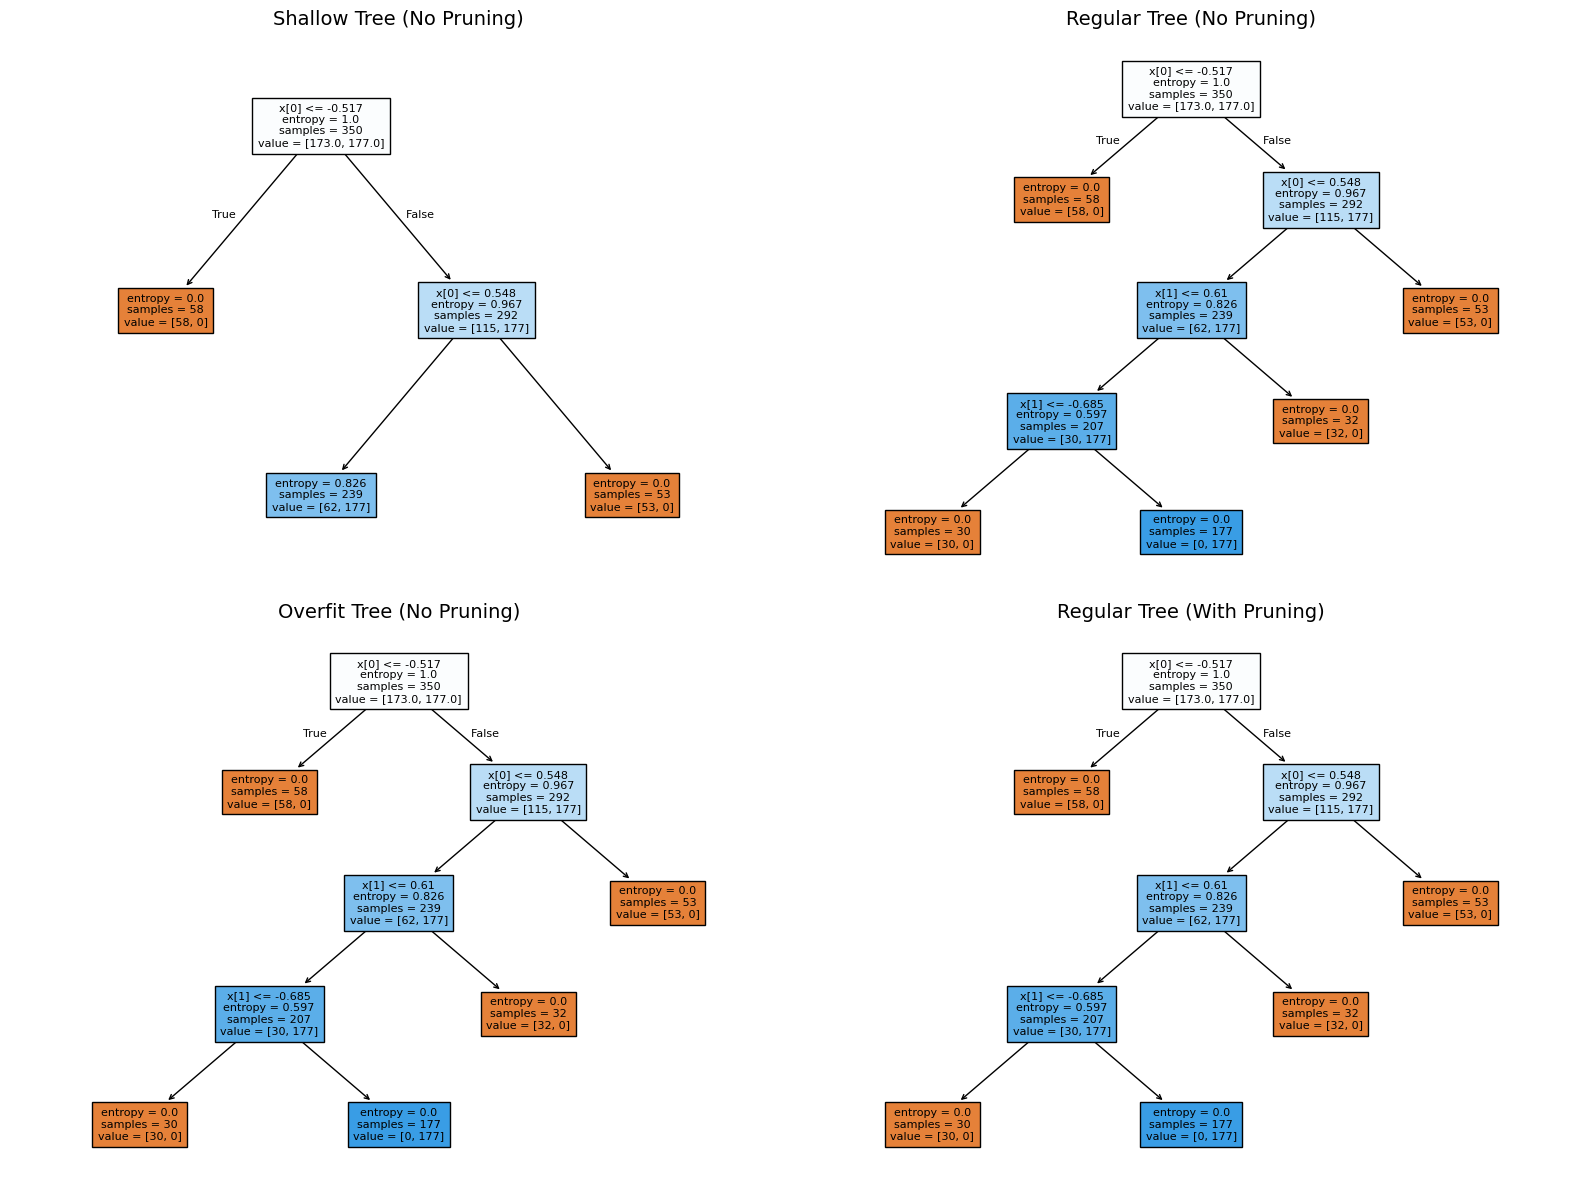

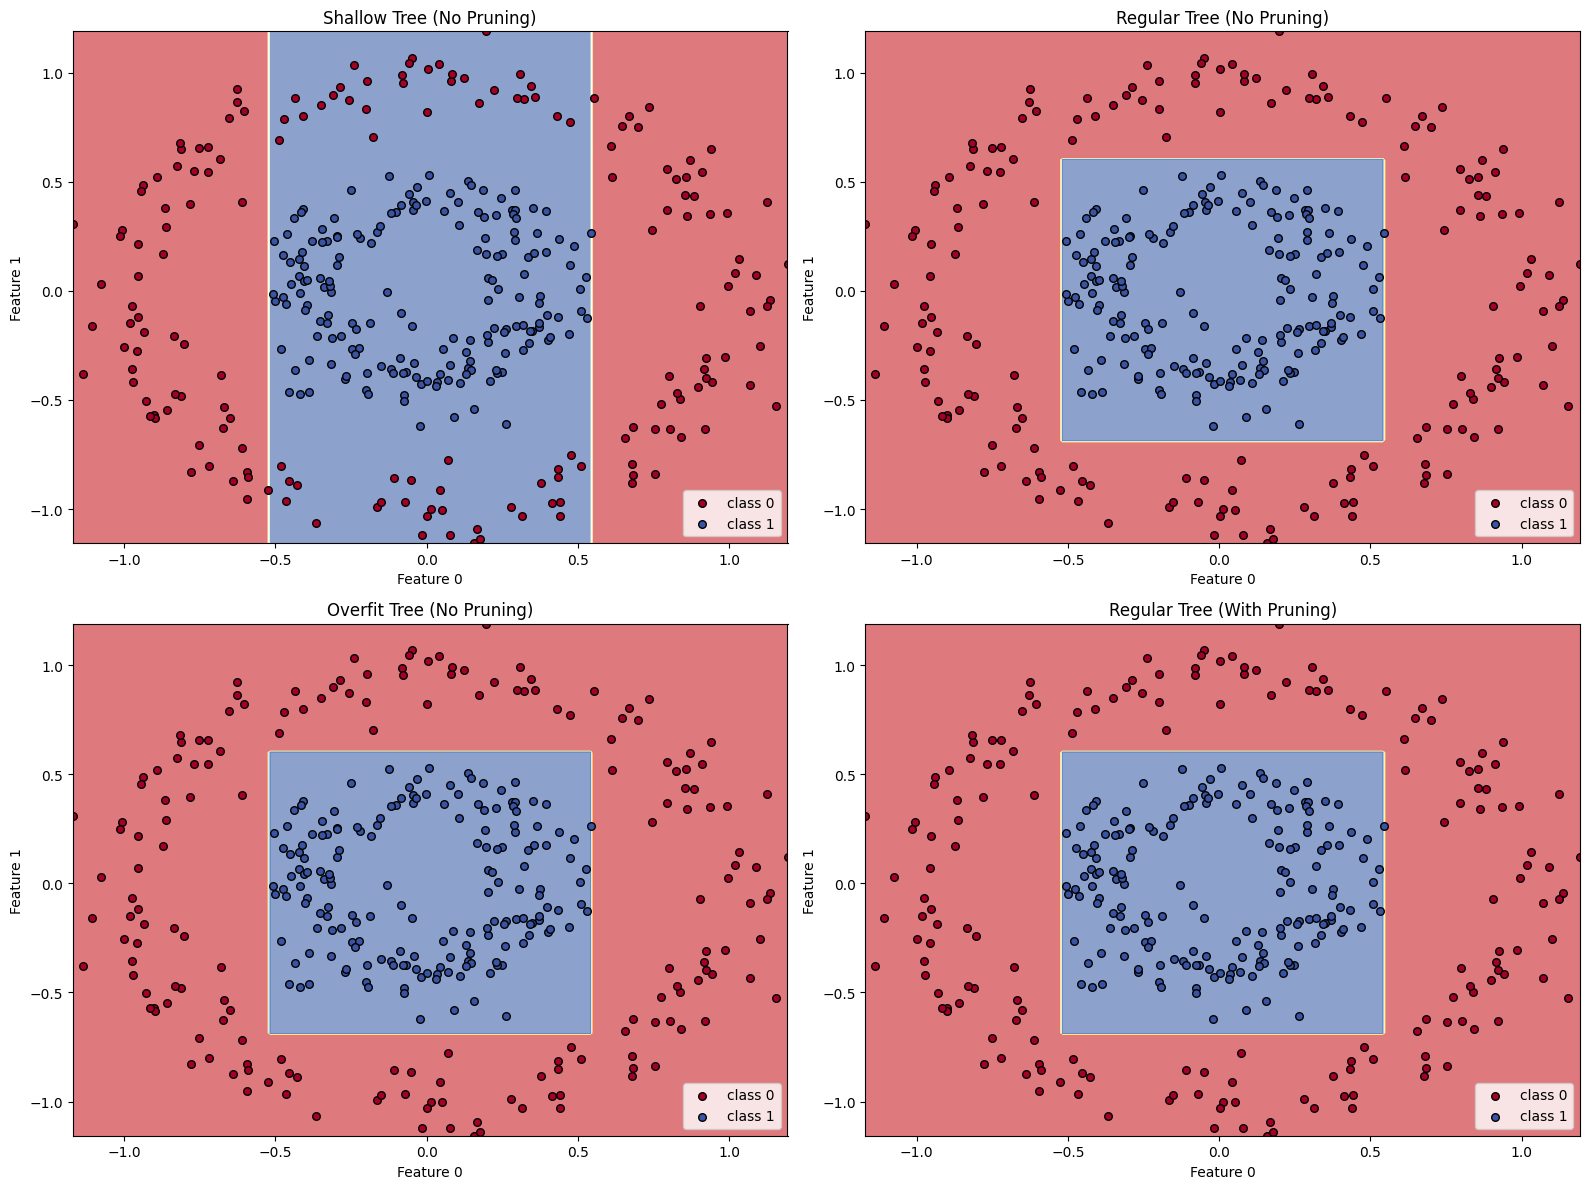

In [18]:
compare_tree_variants(X_train, X_test, y_train, y_test, lmt)

### For the extended dataset

Shallow Tree (No Pruning) - Accuracy: 1.0000, AUC: 1.0000, Log Loss: 0.0000
Regular Tree (No Pruning) - Accuracy: 1.0000, AUC: 1.0000, Log Loss: 0.0000
Overfit Tree (No Pruning) - Accuracy: 1.0000, AUC: 1.0000, Log Loss: 0.0000
Regular Tree (With Pruning) - Accuracy: 1.0000, AUC: 1.0000, Log Loss: 0.0000


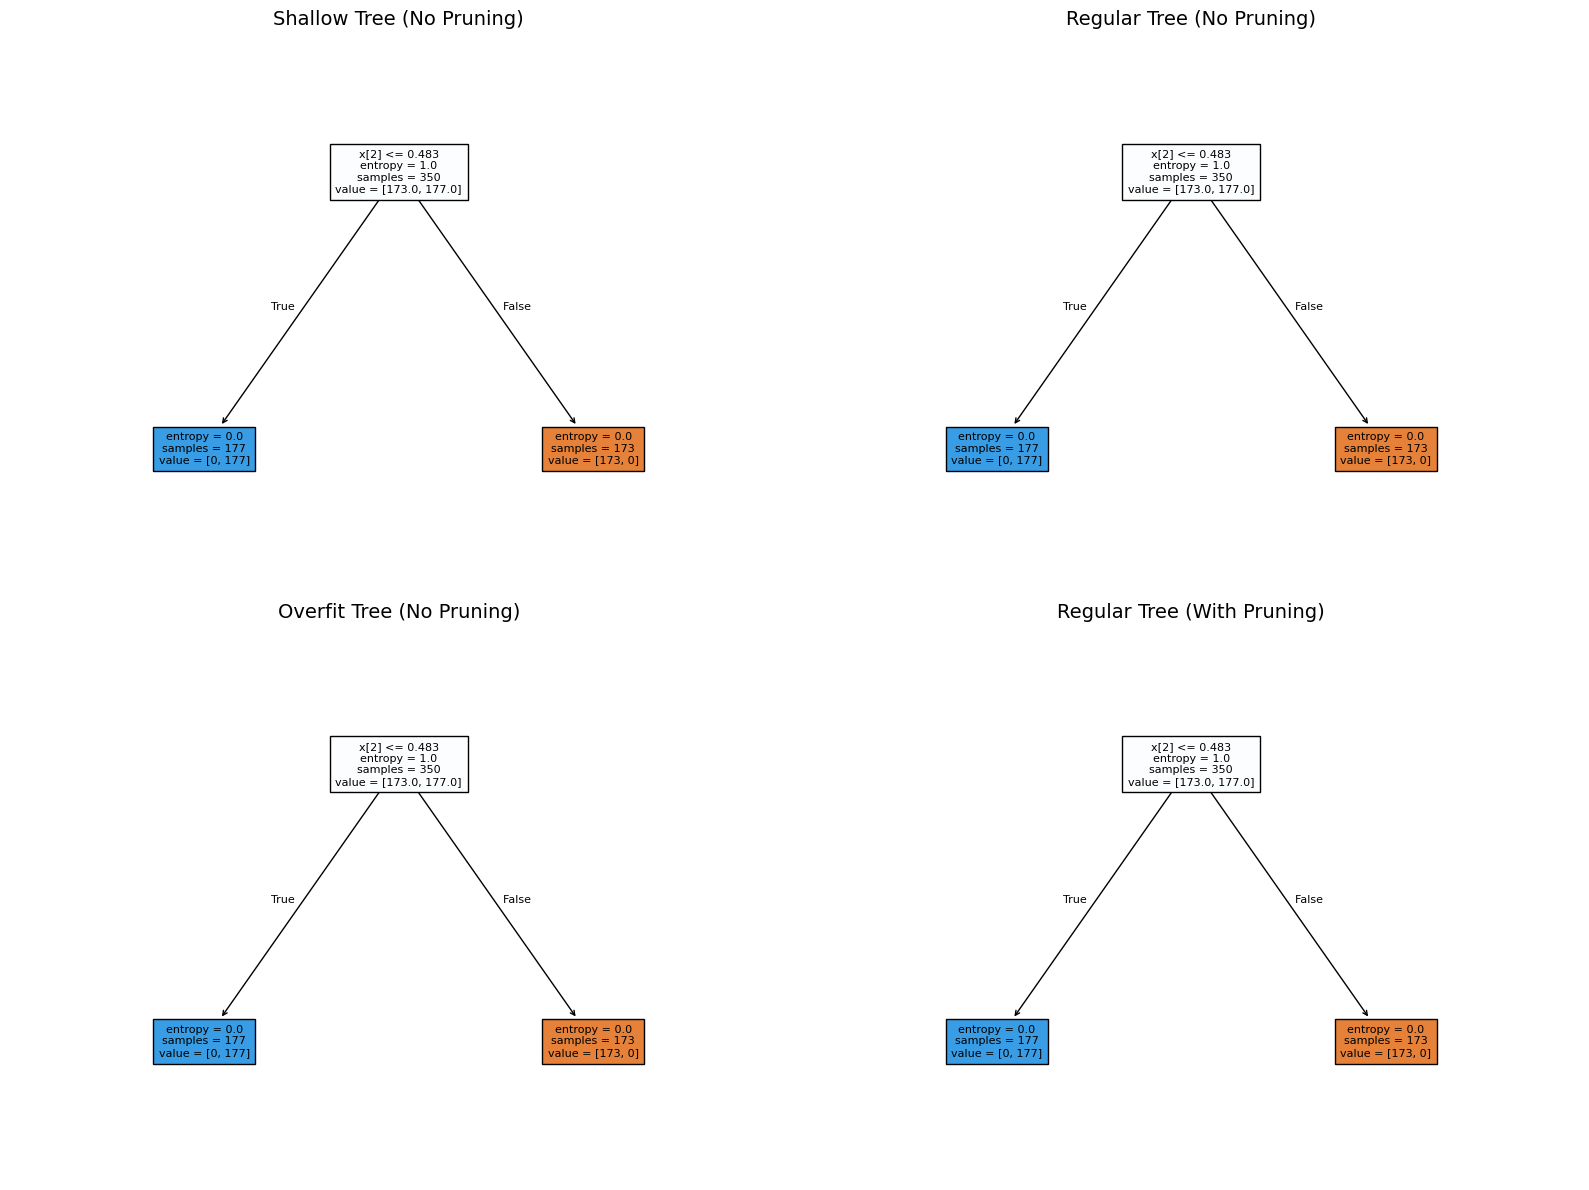

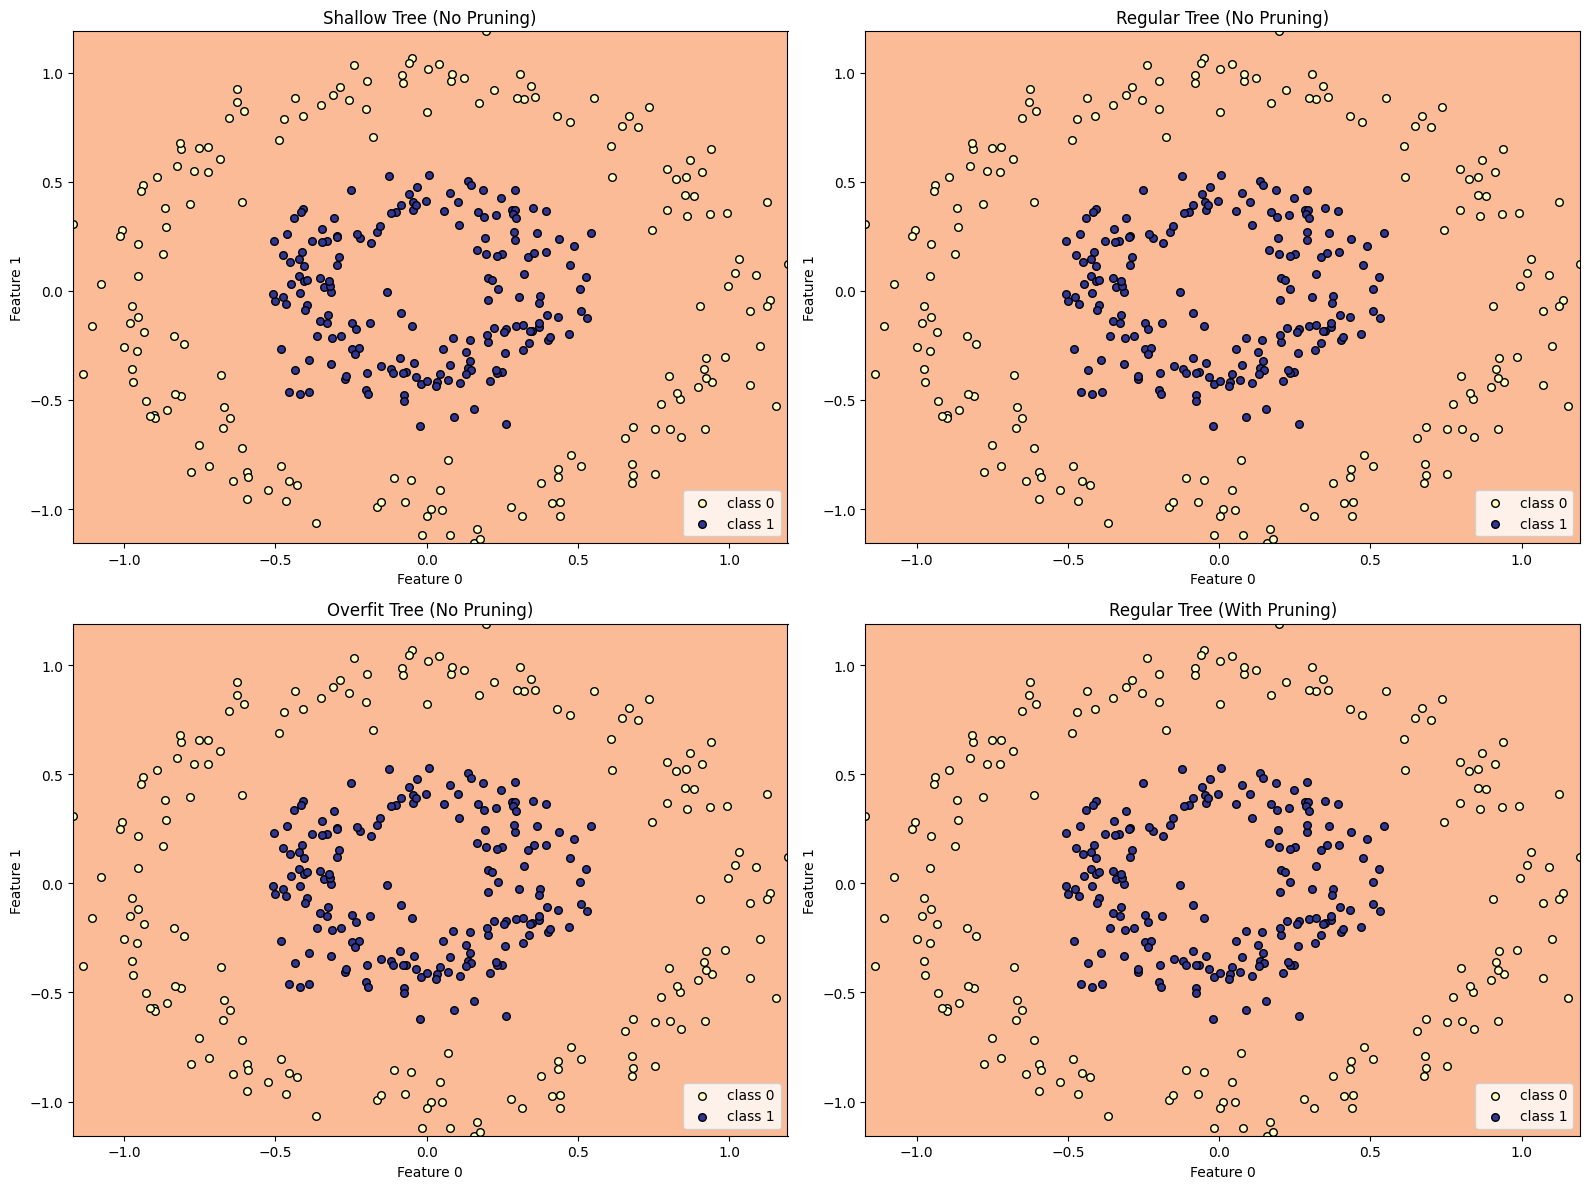

In [19]:
compare_tree_variants(X_train_ext, X_test_ext, y_train_ext, y_test_ext, lmt)

The value that matters is `x[2]`

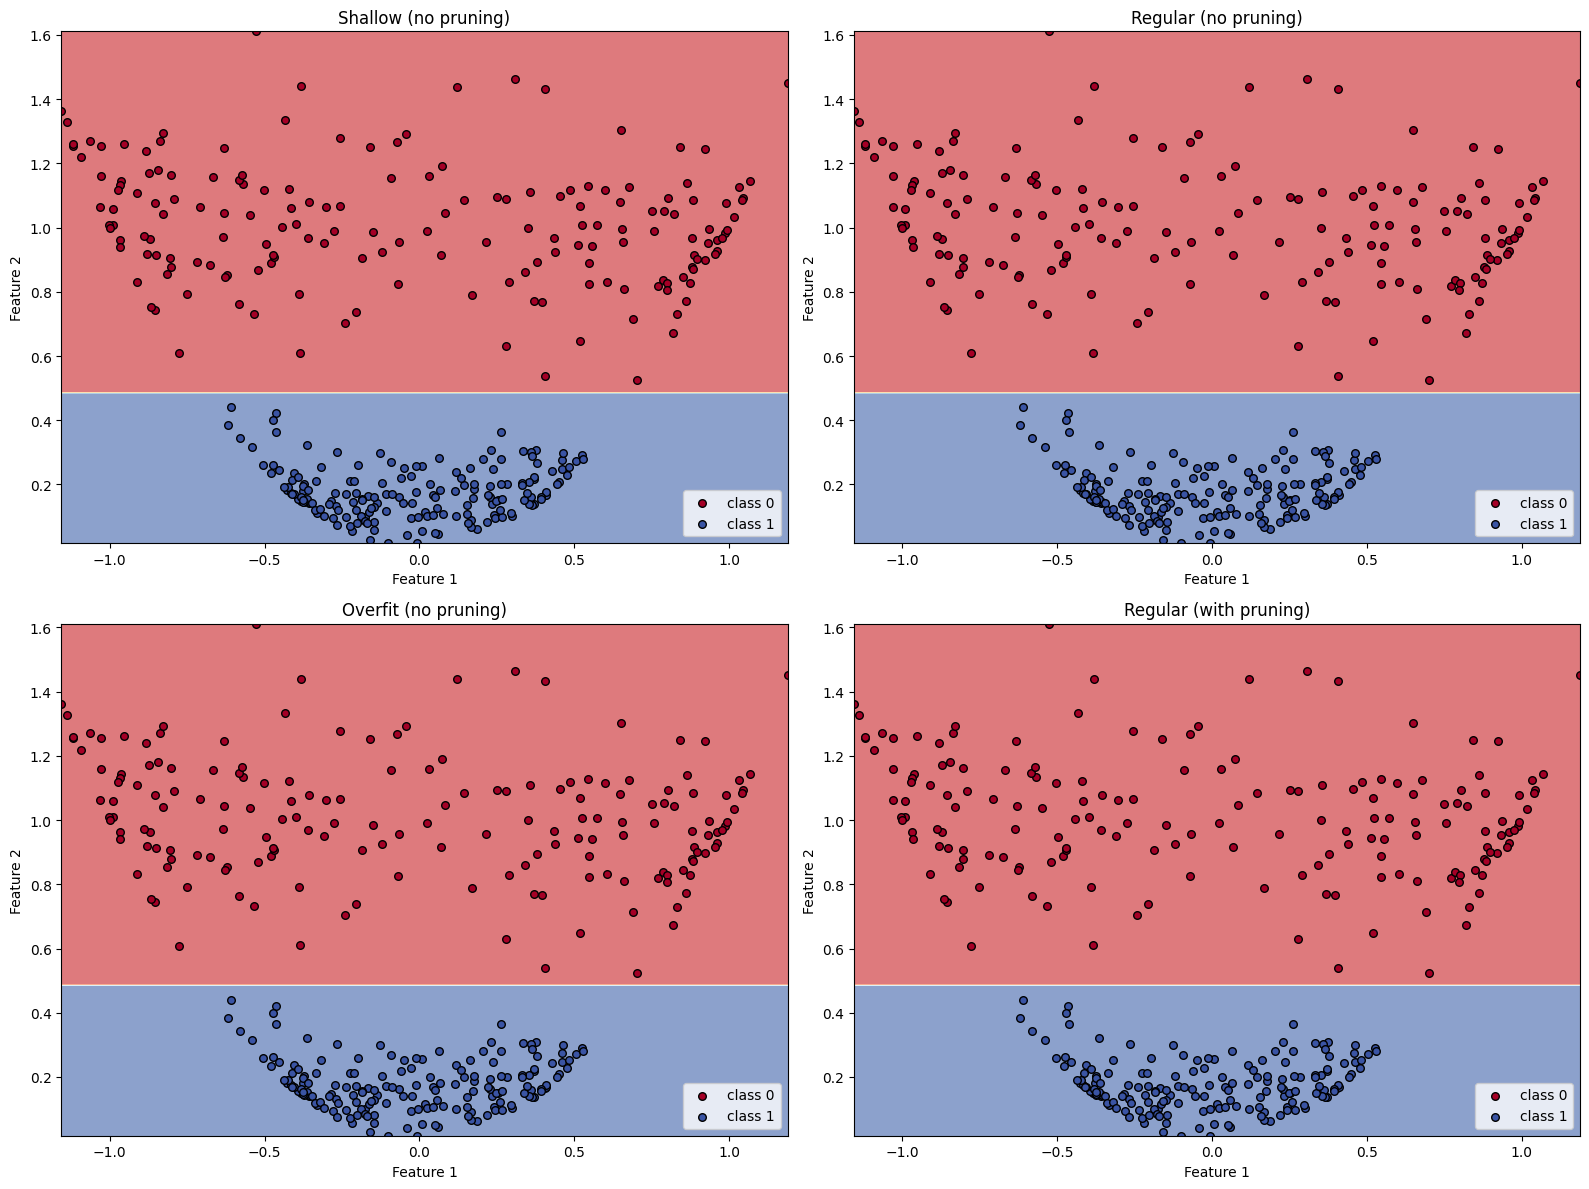

In [ ]:
# Plotting decision surfaces of all four trees
clf_shallow = lmt.construct_tree(X_train_ext, y_train_ext, size='shallow', pruning=False)
clf_regular = lmt.construct_tree(X_train_ext, y_train_ext, size='regular', pruning=False)
clf_overfit = lmt.construct_tree(X_train_ext, y_train_ext, size='overfit', pruning=False)
clf_pruned = lmt.construct_tree(X_train_ext, y_train_ext, size='regular', pruning=True)


clfs       = [clf_shallow,     clf_regular,     clf_overfit,     clf_pruned]
titles     = [
    "Shallow (no pruning)",
    "Regular (no pruning)",
    "Overfit (no pruning)",
    "Regular (with pruning)"
]


fig, axes = plt.subplots(2, 2, figsize=(16, 12))
for ax, clf, title in zip(axes.ravel(), clfs, titles):
    lmt.plot_decision_surface_from_fitted_tree(
        clf_tree=clf,
        X=X_train_ext,
        feature_pair=(1, 2),  # adjust if you want different feature axes
        y=y_train_ext,
        fixed_vals=None,
        grid_steps=200,
        cmap='RdYlBu',
        ax=ax,
        title=title
    )

plt.tight_layout()
plt.show()




### Calibration curves

In [25]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.calibration import CalibrationDisplay
import numpy as np

def plot_calibration_comparison(
    y_true_1, proba_1,
    y_true_2, proba_2,
    label_1="Model 1",
    label_2="Model 2",
    title="Calibration Curves Comparison",
    n_bins=10,
    ax_curve=None,
    ax_hist1=None,
    ax_hist2=None,
    cmap_name="Set2"
):
    colors = plt.get_cmap(cmap_name)

    CalibrationDisplay.from_predictions(
        y_true_1,
        proba_1,
        n_bins=n_bins,
        name=label_1,
        ax=ax_curve,
        color=colors(0),
    )

    CalibrationDisplay.from_predictions(
        y_true_2,
        proba_2,
        n_bins=n_bins,
        name=label_2,
        ax=ax_curve,
        color=colors(1),
    )

    ax_curve.set_title(title)
    ax_curve.grid(True)

    ax_hist1.hist(proba_1, bins=n_bins, range=(0, 1),
                  color=colors(0), alpha=0.75)
    ax_hist1.set(title=label_1, xlabel="Predicted probability", ylabel="Count")

    ax_hist2.hist(proba_2, bins=n_bins, range=(0, 1),
                  color=colors(1), alpha=0.75)
    ax_hist2.set(title=label_2, xlabel="Predicted probability")

def plot_all_calibrations(
    X_test, y_test,
    clf_orig_list,
    X_test_ext, y_test_ext,
    clf_ext_list
):
    titles = [
        "Calibration curves – shallow tree (no pruning)",
        "Calibration curves – regular tree (no pruning)",
        "Calibration curves – overfit tree (no pruning)",
        "Calibration curves – regular tree (with pruning)"
    ]

    fig = plt.figure(figsize=(14, 16))
    outer_gs = GridSpec(nrows=4, ncols=2, figure=fig, height_ratios=[2, 2, 2, 2])

    for idx, title in enumerate(titles):
        ax_curve = fig.add_subplot(outer_gs[idx, 0])
        ax_hists = fig.add_subplot(outer_gs[idx, 1])

        # Get predicted probabilities
        proba_orig = clf_orig_list[idx].predict_proba(X_test)[:, 1]
        proba_ext  = clf_ext_list[idx].predict_proba(X_test_ext)[:, 1]

        # Plot calibration and histograms side-by-side
        plot_calibration_comparison(
            y_true_1=y_test,
            proba_1=proba_orig,
            y_true_2=y_test_ext,
            proba_2=proba_ext,
            label_1="Original",
            label_2="Extended",
            title=title,
            ax_curve=ax_curve,
            ax_hist1=ax_hists,
            ax_hist2=ax_hists  # Overlay both hists on same subplot
        )

        # Overlay legend manually since we draw both hists in same ax
        ax_hists.legend(["Original", "Extended"])

    fig.tight_layout()
    plt.show()


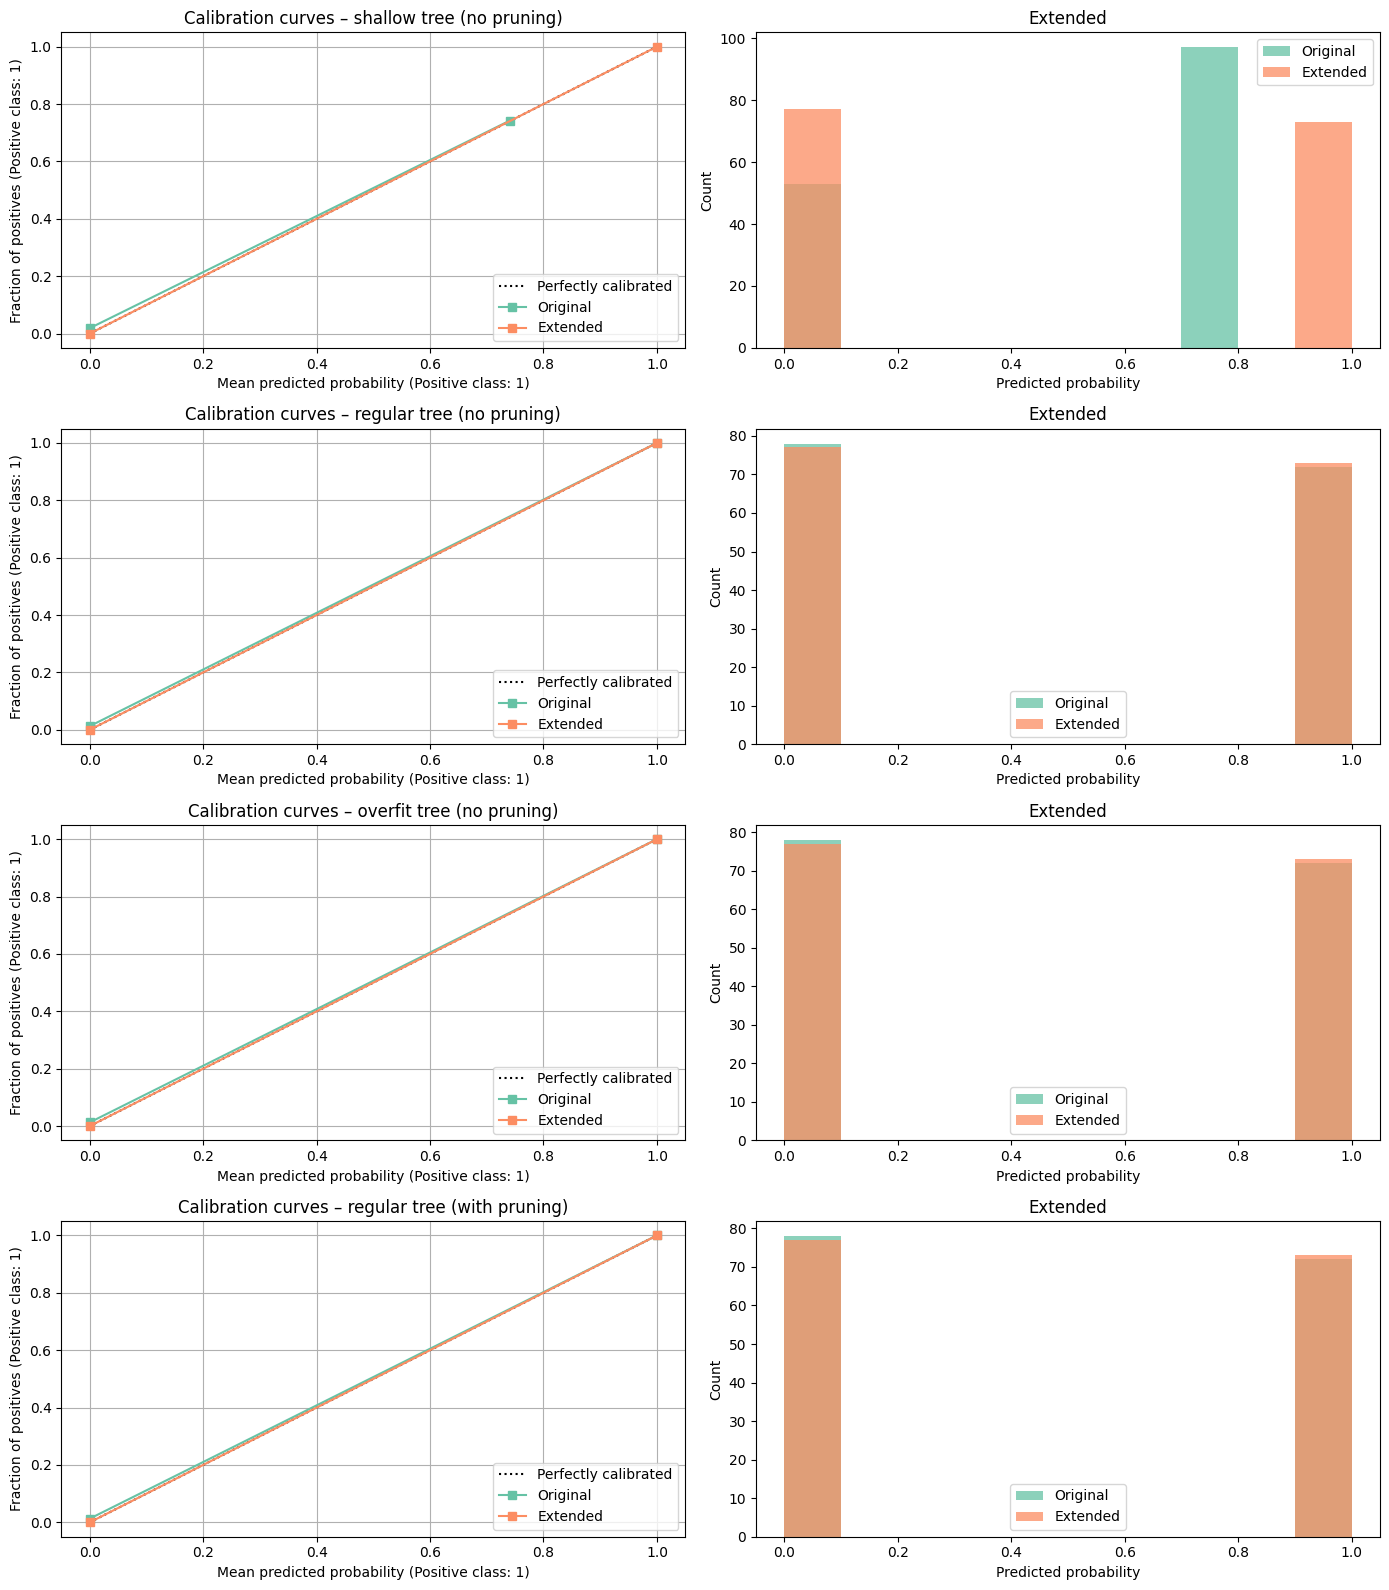

In [26]:
clf_shallow     = lmt.construct_tree(X_train,     y_train,     size='shallow', pruning=False)
clf_regular     = lmt.construct_tree(X_train,     y_train,     size='regular', pruning=False)
clf_overfit     = lmt.construct_tree(X_train,     y_train,     size='overfit', pruning=False)
clf_pruned      = lmt.construct_tree(X_train,     y_train,     size='regular', pruning=True)

clf_shallow_ext = lmt.construct_tree(X_train_ext, y_train_ext, size='shallow', pruning=False)
clf_regular_ext = lmt.construct_tree(X_train_ext, y_train_ext, size='regular', pruning=False)
clf_overfit_ext = lmt.construct_tree(X_train_ext, y_train_ext, size='overfit', pruning=False)
clf_pruned_ext  = lmt.construct_tree(X_train_ext, y_train_ext, size='regular', pruning=True)

# Call the plotting function
plot_all_calibrations(
    X_test, y_test,
    clf_orig_list=[clf_shallow, clf_regular, clf_overfit, clf_pruned],
    X_test_ext=X_test_ext, y_test_ext=y_test_ext,
    clf_ext_list=[clf_shallow_ext, clf_regular_ext, clf_overfit_ext, clf_pruned_ext]
)


In [27]:
# Tree classifiers (already trained)
clf_orig_list = [clf_shallow, clf_regular, clf_overfit, clf_pruned]
clf_ext_list  = [clf_shallow_ext, clf_regular_ext, clf_overfit_ext, clf_pruned_ext]

# Corresponding labels
labels = [
    "Shallow tree - No pruning",
    "Regular tree - No pruning",
    "Overfit tree - No pruning",
    "Regular tree - With pruning"
]

# Inputs
X_test_sets  = [X_test, X_test_ext]
y_test_sets  = [y_test, y_test_ext]
clf_sets     = [clf_orig_list, clf_ext_list]
suffixes     = ["(original)", "(extended)"]

# Metrics collection
scores = defaultdict(list)

# Loop over both original and extended classifiers
for clf_list, X_te, y_te, suffix in zip(clf_sets, X_test_sets, y_test_sets, suffixes):
    for clf, label in zip(clf_list, labels):
        name = f"{label} {suffix}"

        # Predictions
        y_prob = clf.predict_proba(X_te)[:, 1]
        y_pred = clf.predict(X_te)

        scores["Classifier"].append(name)

        # Probabilistic metrics
        for metric in (brier_score_loss, log_loss, roc_auc_score):
            col = metric.__name__.replace("_", " ").replace("score", "").capitalize()
            scores[col].append(metric(y_te, y_prob))

        # Discrete metrics
        for metric in (precision_score, recall_score, f1_score):
            col = metric.__name__.replace("_", " ").replace("score", "").capitalize()
            scores[col].append(metric(y_te, y_pred))

# Create DataFrame
tree_score_df = (
    pd.DataFrame(scores)
      .set_index("Classifier")
      .round(4)
      .sort_index()
)

print(tree_score_df)

                                        Brier  loss  Log loss  Roc auc   \
Classifier                                                                
Overfit tree - No pruning (extended)         0.0000    0.0000    1.0000   
Overfit tree - No pruning (original)         0.0067    0.2403    0.9932   
Regular tree - No pruning (extended)         0.0000    0.0000    1.0000   
Regular tree - No pruning (original)         0.0067    0.2403    0.9932   
Regular tree - With pruning (extended)       0.0000    0.0000    1.0000   
Regular tree - With pruning (original)       0.0067    0.2403    0.9932   
Shallow tree - No pruning (extended)         0.0000    0.0000    1.0000   
Shallow tree - No pruning (original)         0.1304    0.6093    0.8308   

                                        Precision   Recall      F1   
Classifier                                                           
Overfit tree - No pruning (extended)        1.0000   1.0000  1.0000  
Overfit tree - No pruning (original)   

## LMT implementation version with *SimpleLogistic* routine at every node

### For the original dataset

In [ ]:
def compare_lmt_variants(X_train, X_test, y_train, y_test, lmt):
    """
    Trains and evaluates four logistic model trees using different sizes and pruning strategies.
    Plots the tree structure and prints evaluation metrics.
    
    Parameters
    ----------
    X_train, X_test : pd.DataFrame or np.ndarray
        Training and test feature sets.
    y_train, y_test : pd.Series or np.ndarray
        Training and test labels.
    lmt : module or object
        Module or object that provides the `construct_tree` method.
    """
    
    configs = [
        ('shallow', False, "Shallow Tree (No Pruning)"),
        ('regular', False, "Regular Tree (No Pruning)"),
        ('overfit', False, "Overfit Tree (No Pruning)"),
        ('regular', True,  "Regular Tree (With Pruning)")
    ]

    fitted = []

    # Tree construction
    for size, pruning, label in configs:
        clf_tree, node_models = lmt.fit_logistic_model_tree(X_train, y_train, size=size, pruning=pruning)
        # Hard predictions
        y_pred = lmt.predict_lmt(X_test, clf_tree, node_models)
        # extract per‐sample proba. of class 1
        y_prob = lmt.predict_proba_lmt(X_test, clf_tree, node_models)

        # 4) metrics
        acc  = accuracy_score(y_test, y_pred)
        auc  = roc_auc_score(y_test, y_prob)
        loss = log_loss(y_test, y_prob)
        print(f"{label} → Accuracy: {acc:.4f}, AUC: {auc:.4f}, Log Loss: {loss:.4f}")
        
        fitted.append((clf_tree, node_models, label))

    # Plotting all four trees
    for clf_tree, node_models, label in fitted:
        plt.figure(figsize=(16, 8))
        lmt.plot_tree_with_linear_models(
            clf_tree, node_models,
            X=X_train,
            title=label
        )
        plt.tight_layout()
        plt.show()


    # Plotting decision surfaces of all four trees
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    for ax, (clf_tree, _, label) in zip(axes.ravel(), fitted):
        lmt.plot_decision_surface_from_fitted_tree(
            clf_tree=clf_tree,
            X=X_train,
            feature_pair=(0, 1),
            y=y_train,
            fixed_vals=None,
            grid_steps=200,
            cmap='RdYlBu',
            ax=ax,
            title=label
        )
    plt.tight_layout()
    plt.show()



Shallow Tree (No Pruning) → Accuracy: 0.6133, AUC: 0.5111, Log Loss: 0.6935
Regular Tree (No Pruning) → Accuracy: 0.6133, AUC: 0.9909, Log Loss: 0.3662
Overfit Tree (No Pruning) → Accuracy: 0.6133, AUC: 0.9909, Log Loss: 0.3662
Regular Tree (With Pruning) → Accuracy: 0.6133, AUC: 0.9909, Log Loss: 0.3662


<Figure size 1600x800 with 0 Axes>

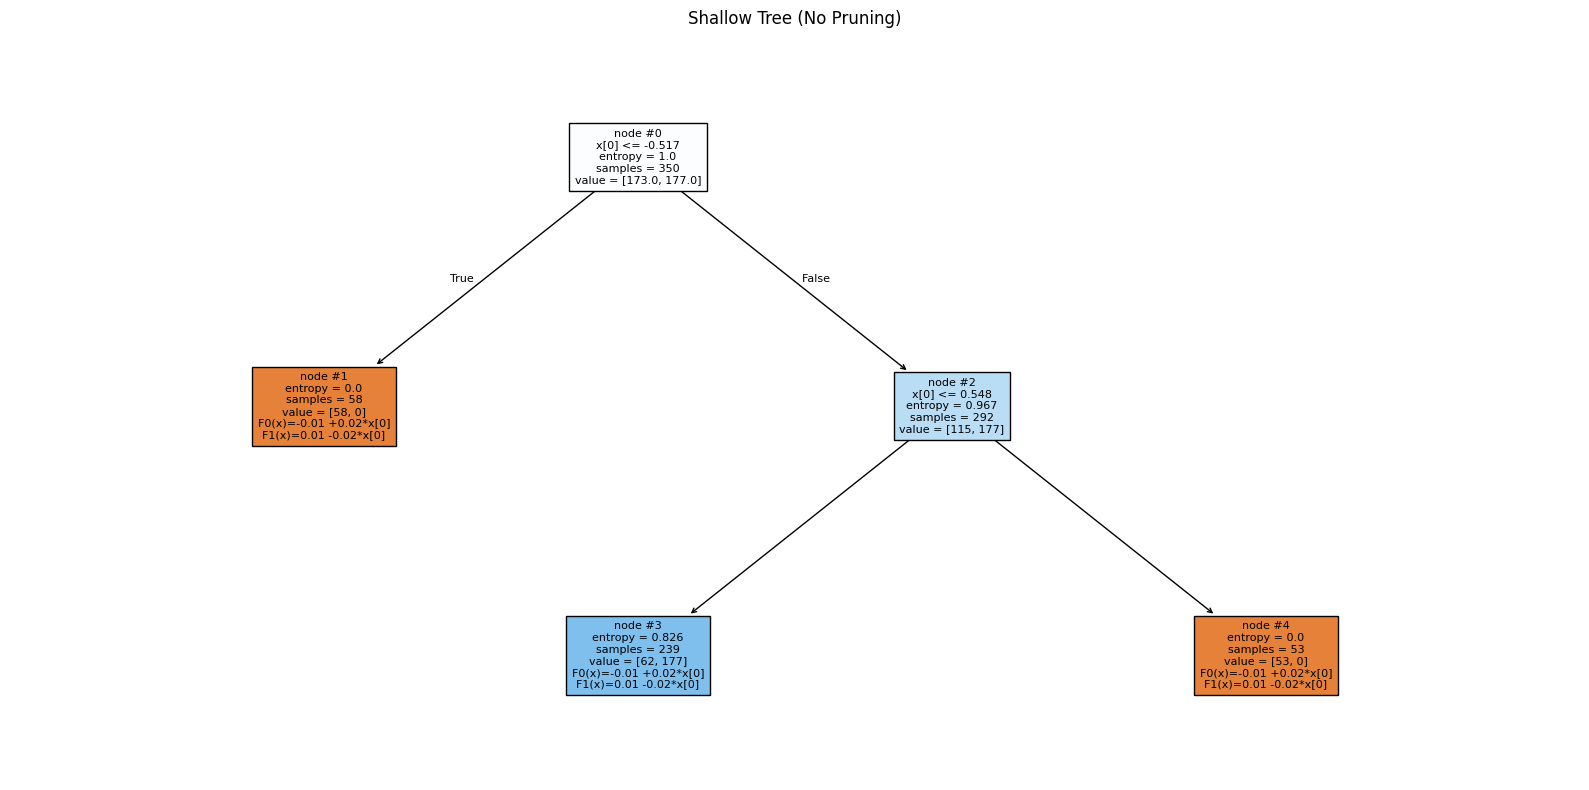

<Figure size 640x480 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

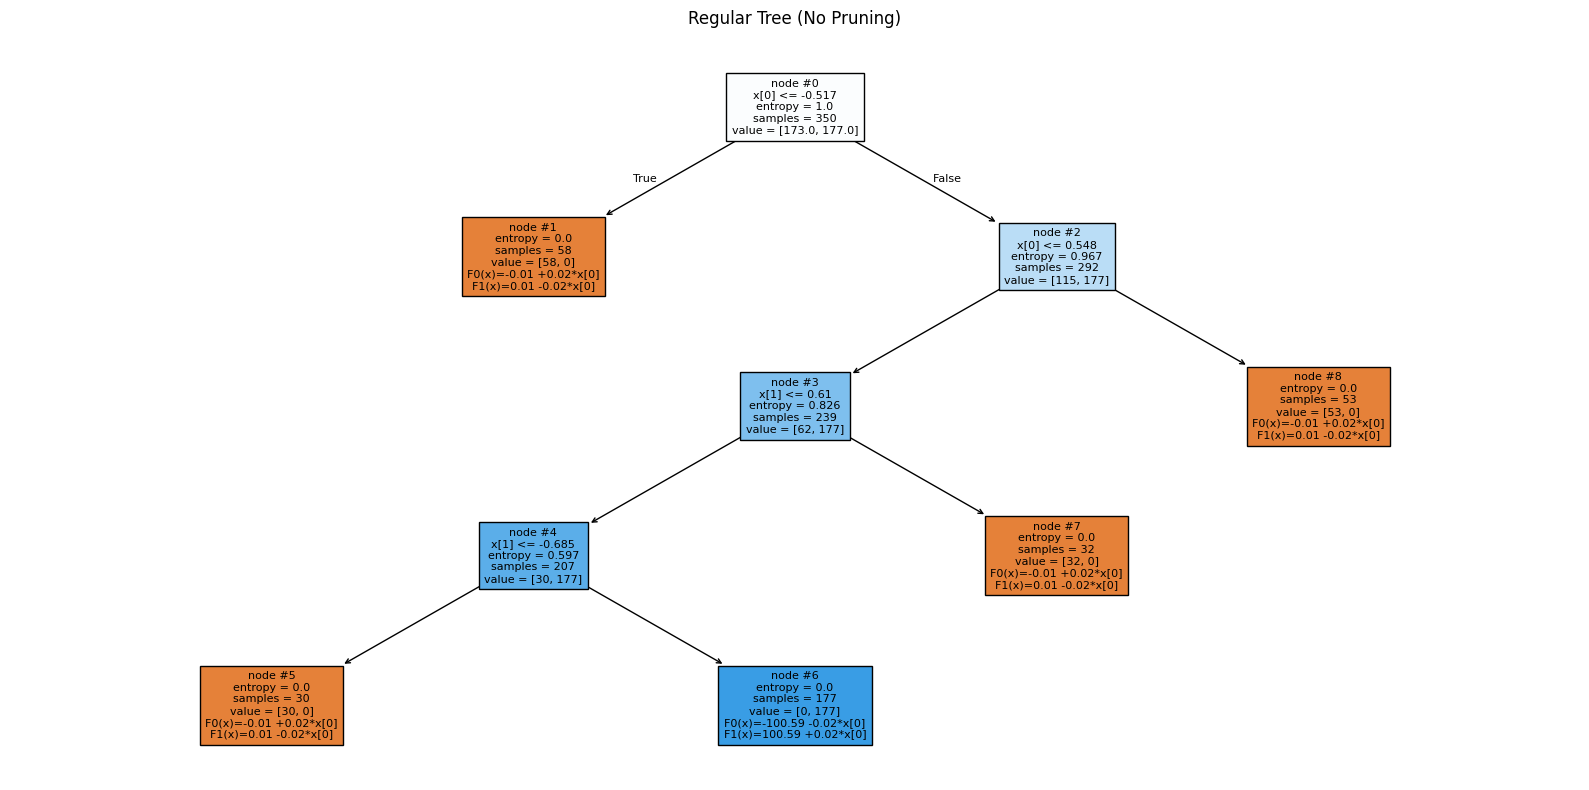

<Figure size 640x480 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

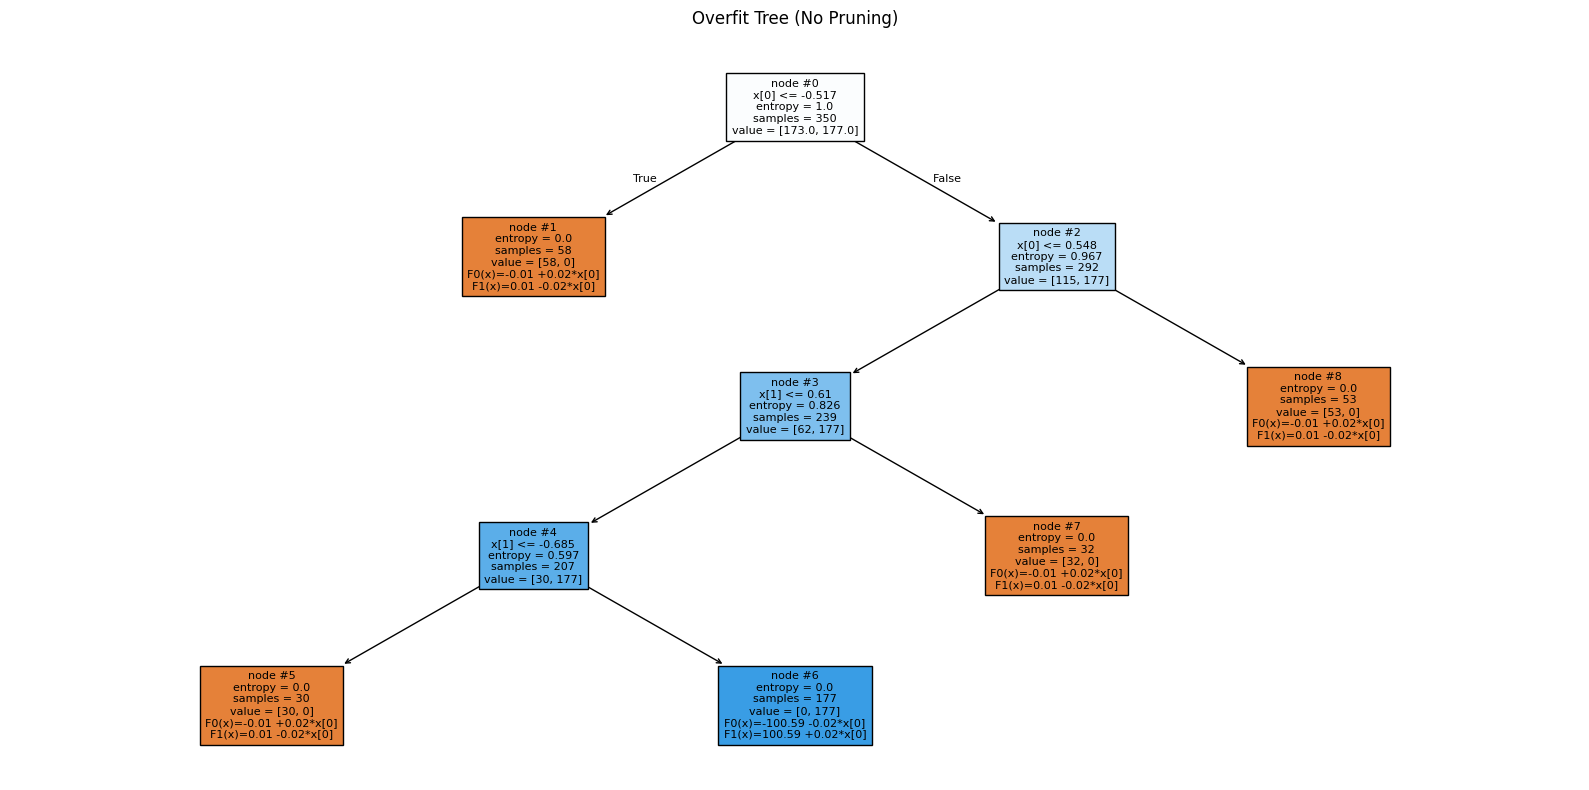

<Figure size 640x480 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

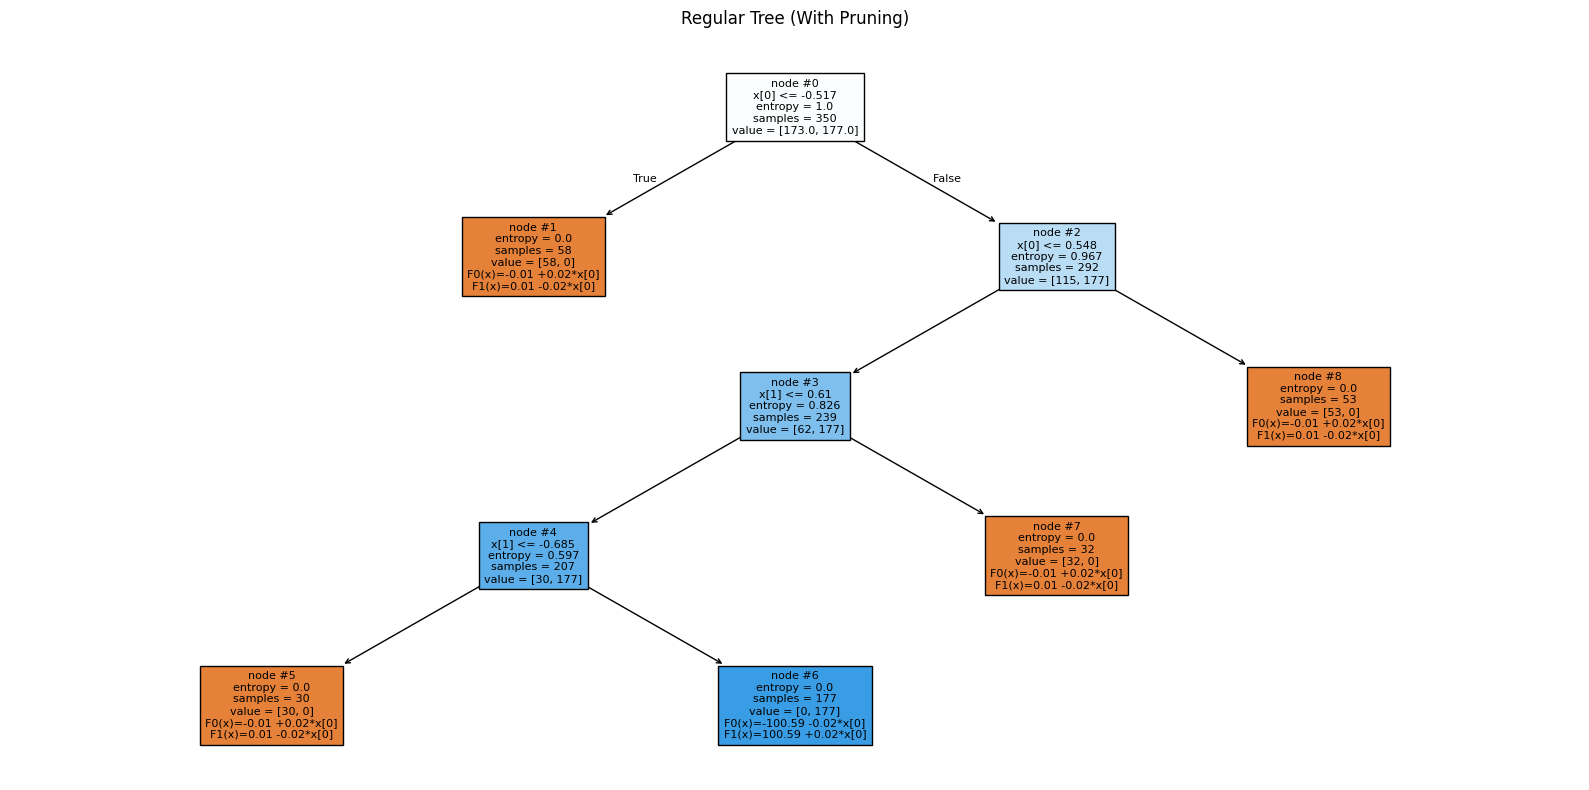

<Figure size 640x480 with 0 Axes>

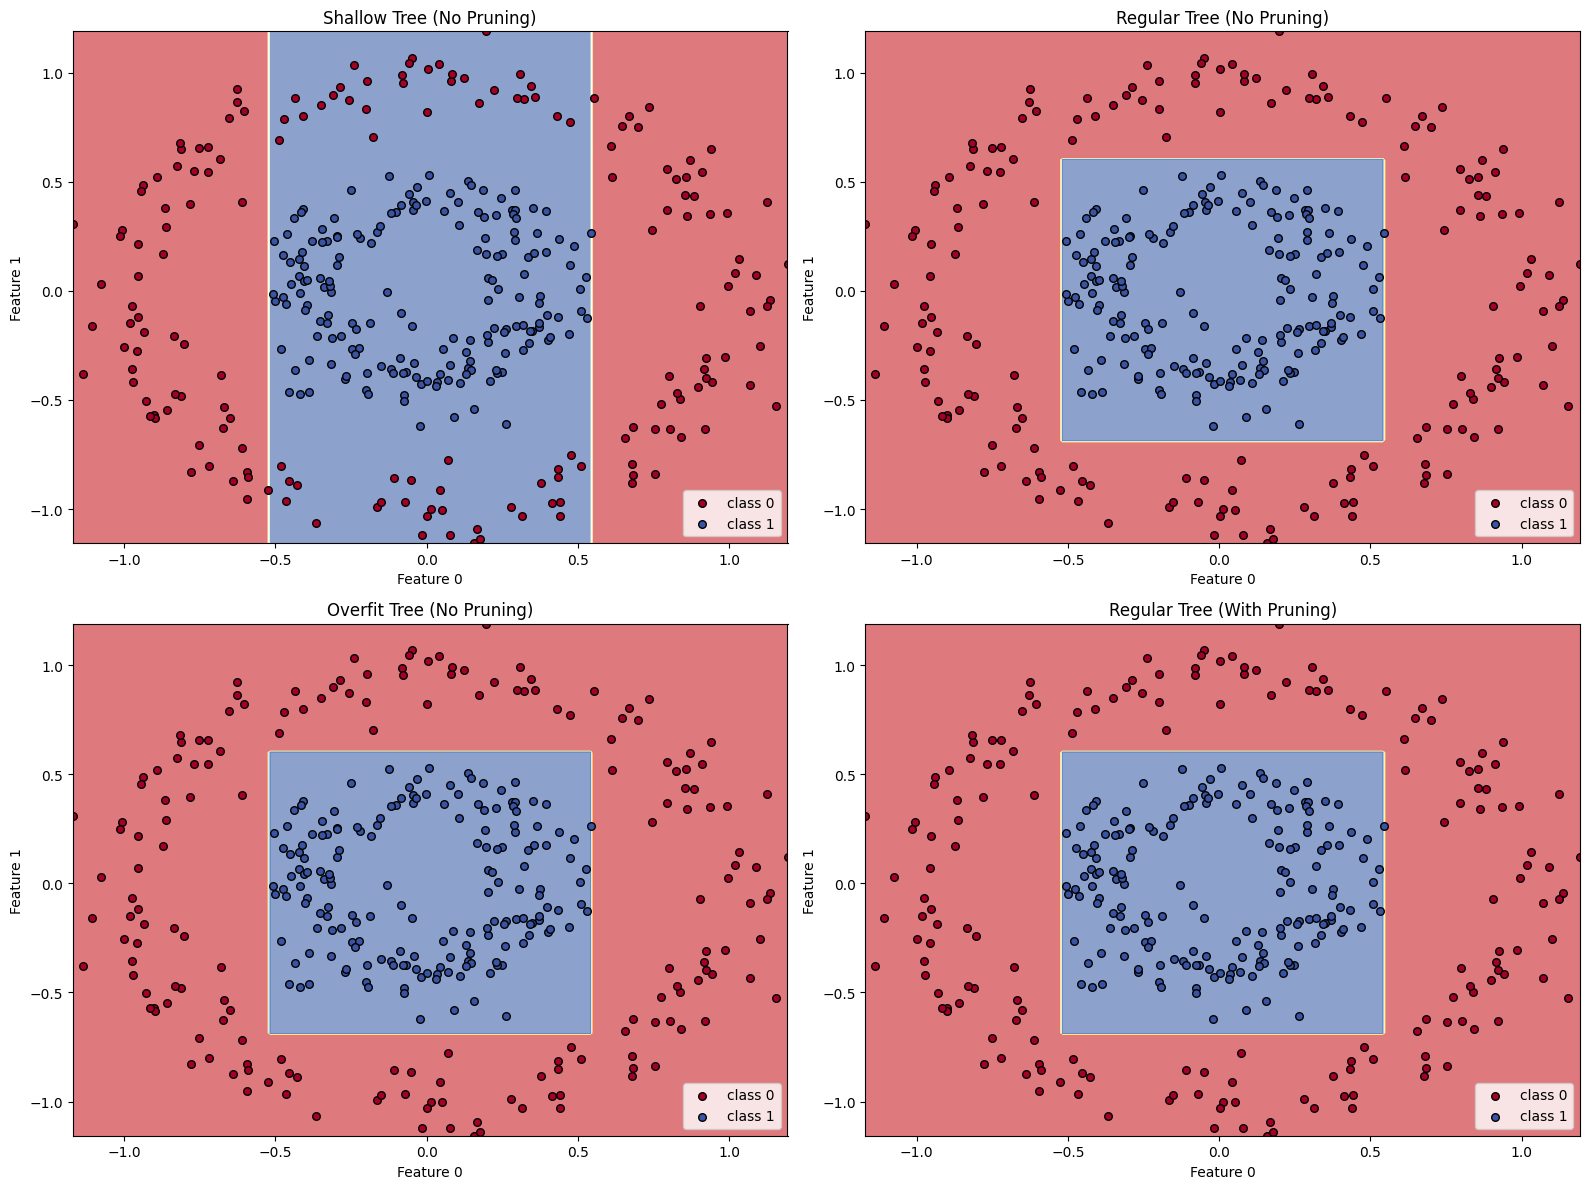

In [31]:
compare_lmt_variants(X_train, X_test, y_train, y_test, lmt)

### For the extended dataset

Shallow Tree (No Pruning) → Accuracy: 1.0000, AUC: 1.0000, Log Loss: 0.0865
Regular Tree (No Pruning) → Accuracy: 1.0000, AUC: 1.0000, Log Loss: 0.0865
Overfit Tree (No Pruning) → Accuracy: 1.0000, AUC: 1.0000, Log Loss: 0.0865
Regular Tree (With Pruning) → Accuracy: 1.0000, AUC: 1.0000, Log Loss: 0.0865


<Figure size 1600x800 with 0 Axes>

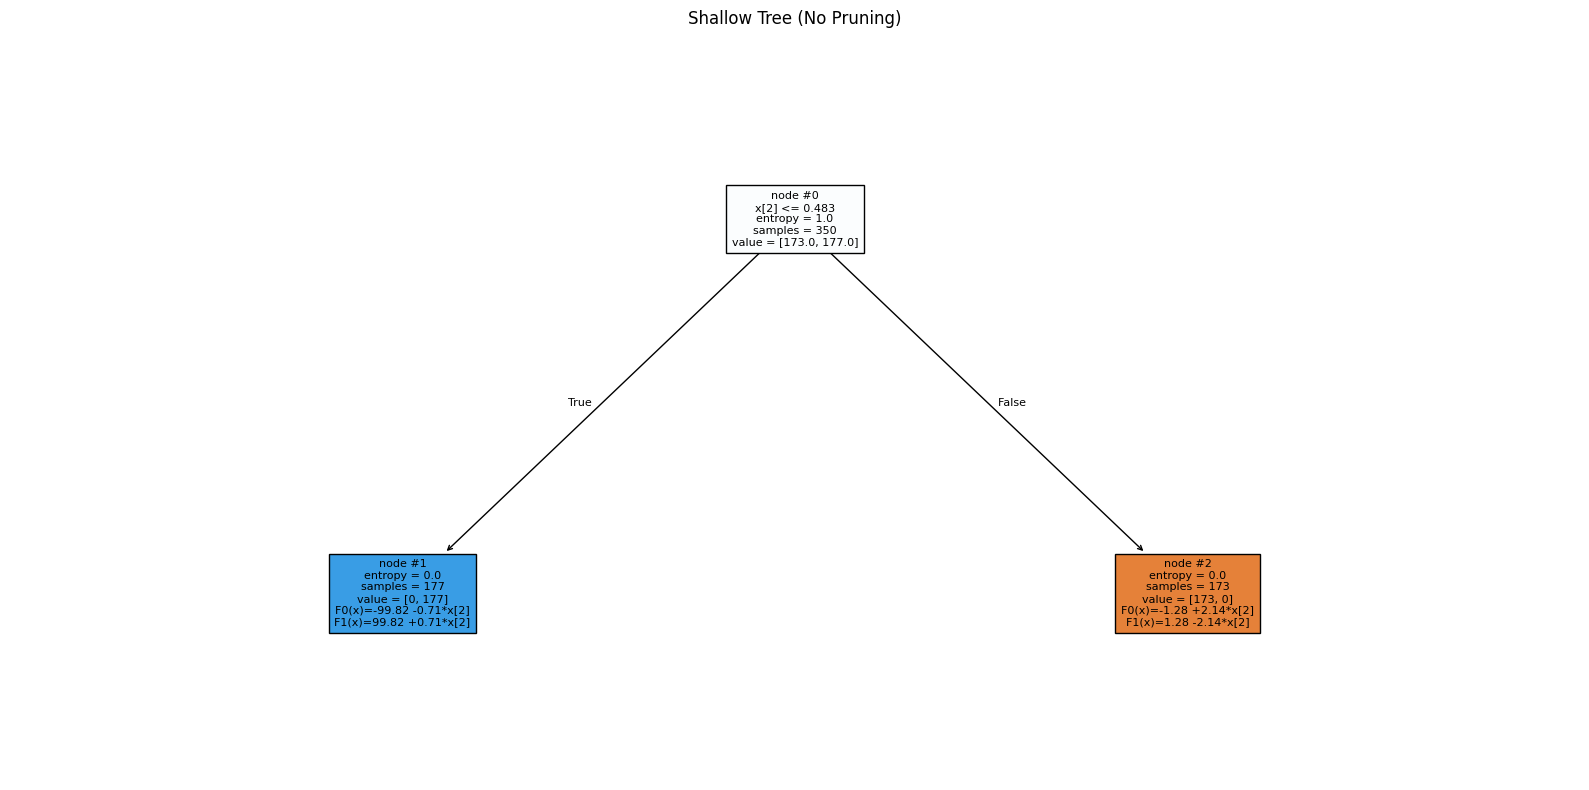

<Figure size 640x480 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

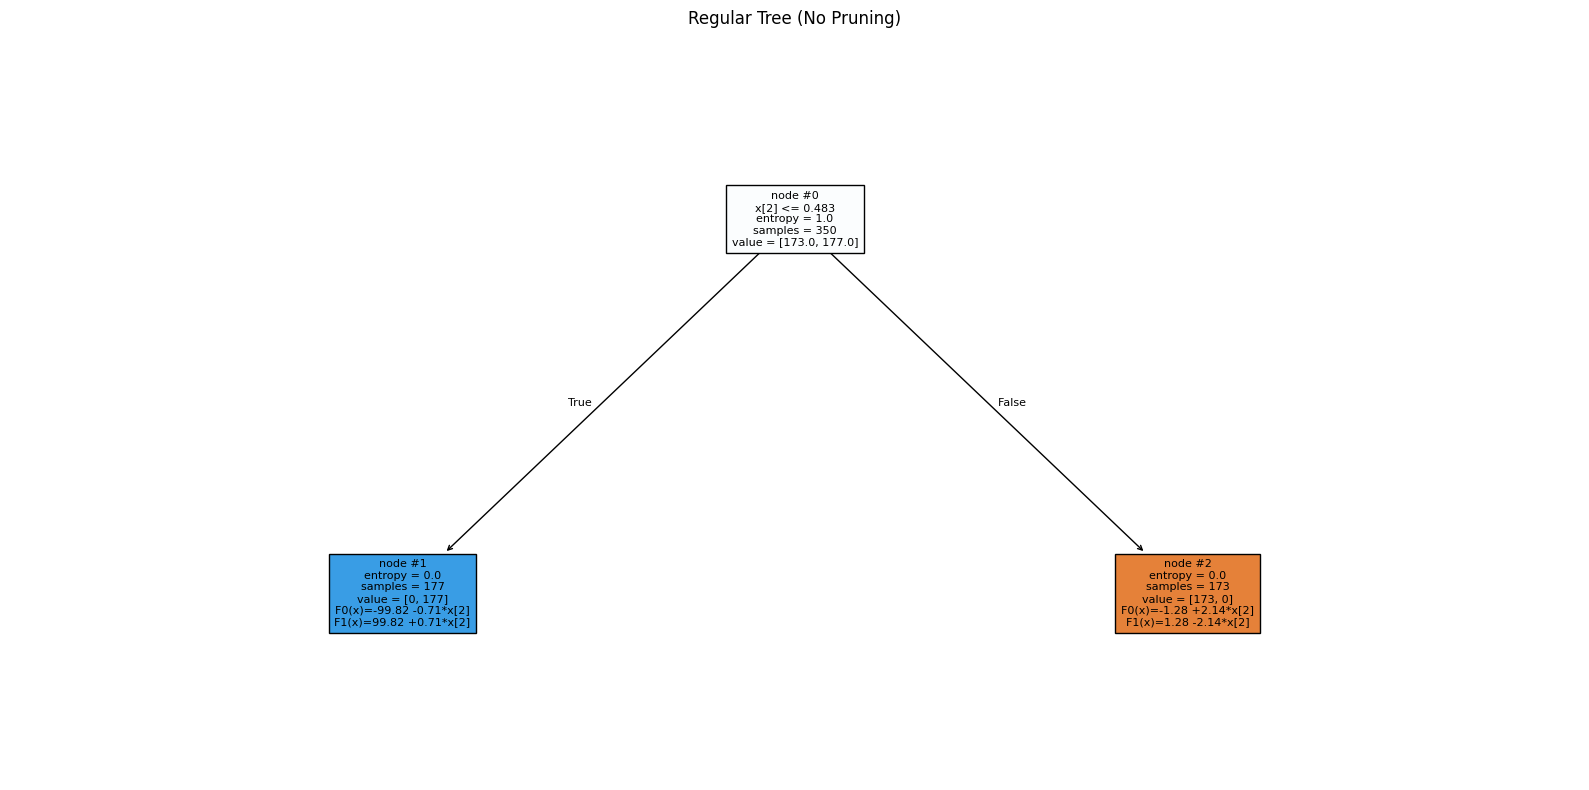

<Figure size 640x480 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

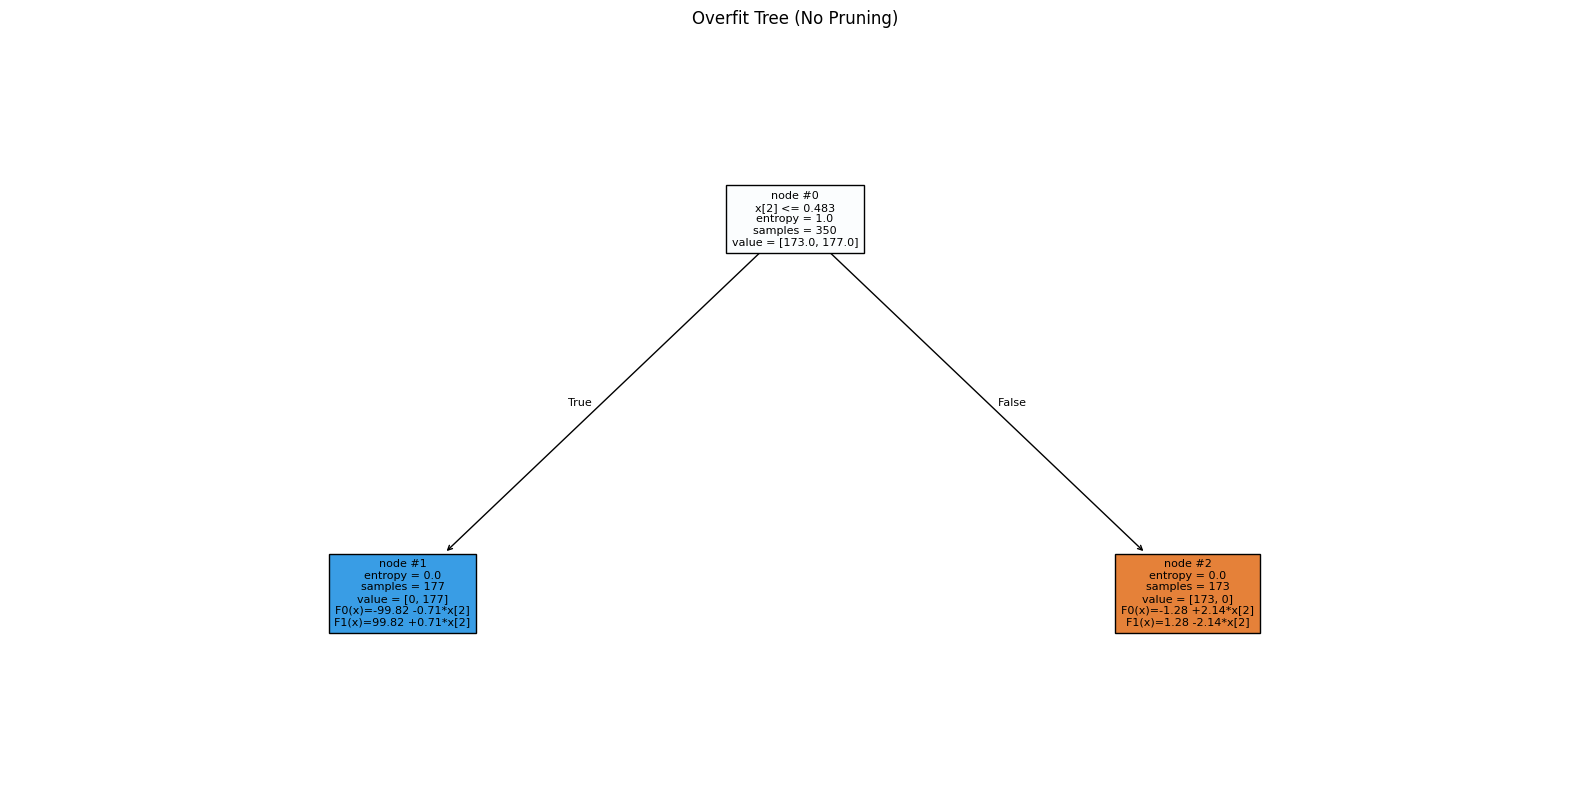

<Figure size 640x480 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

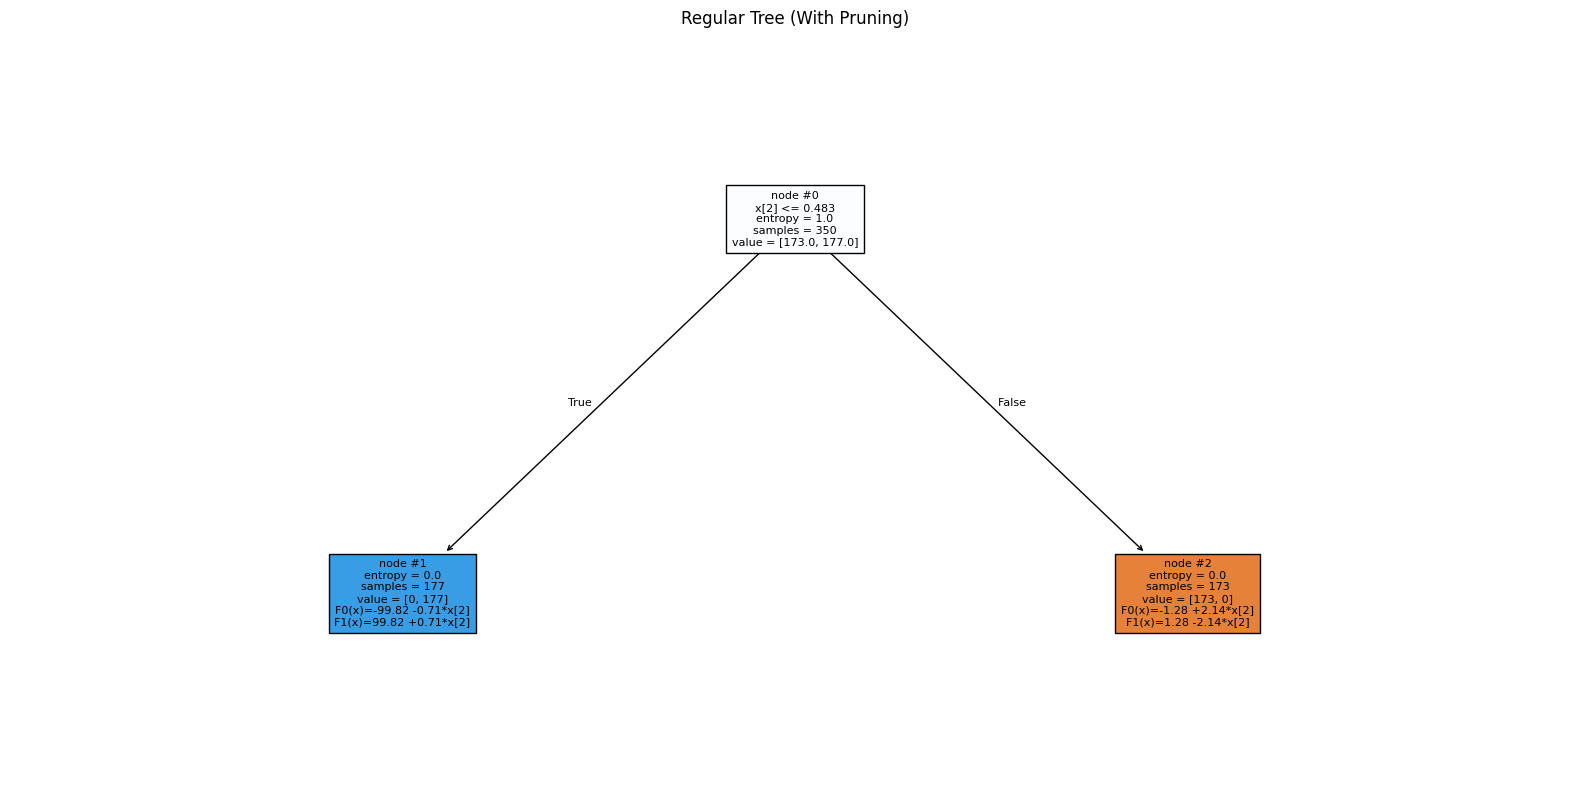

<Figure size 640x480 with 0 Axes>

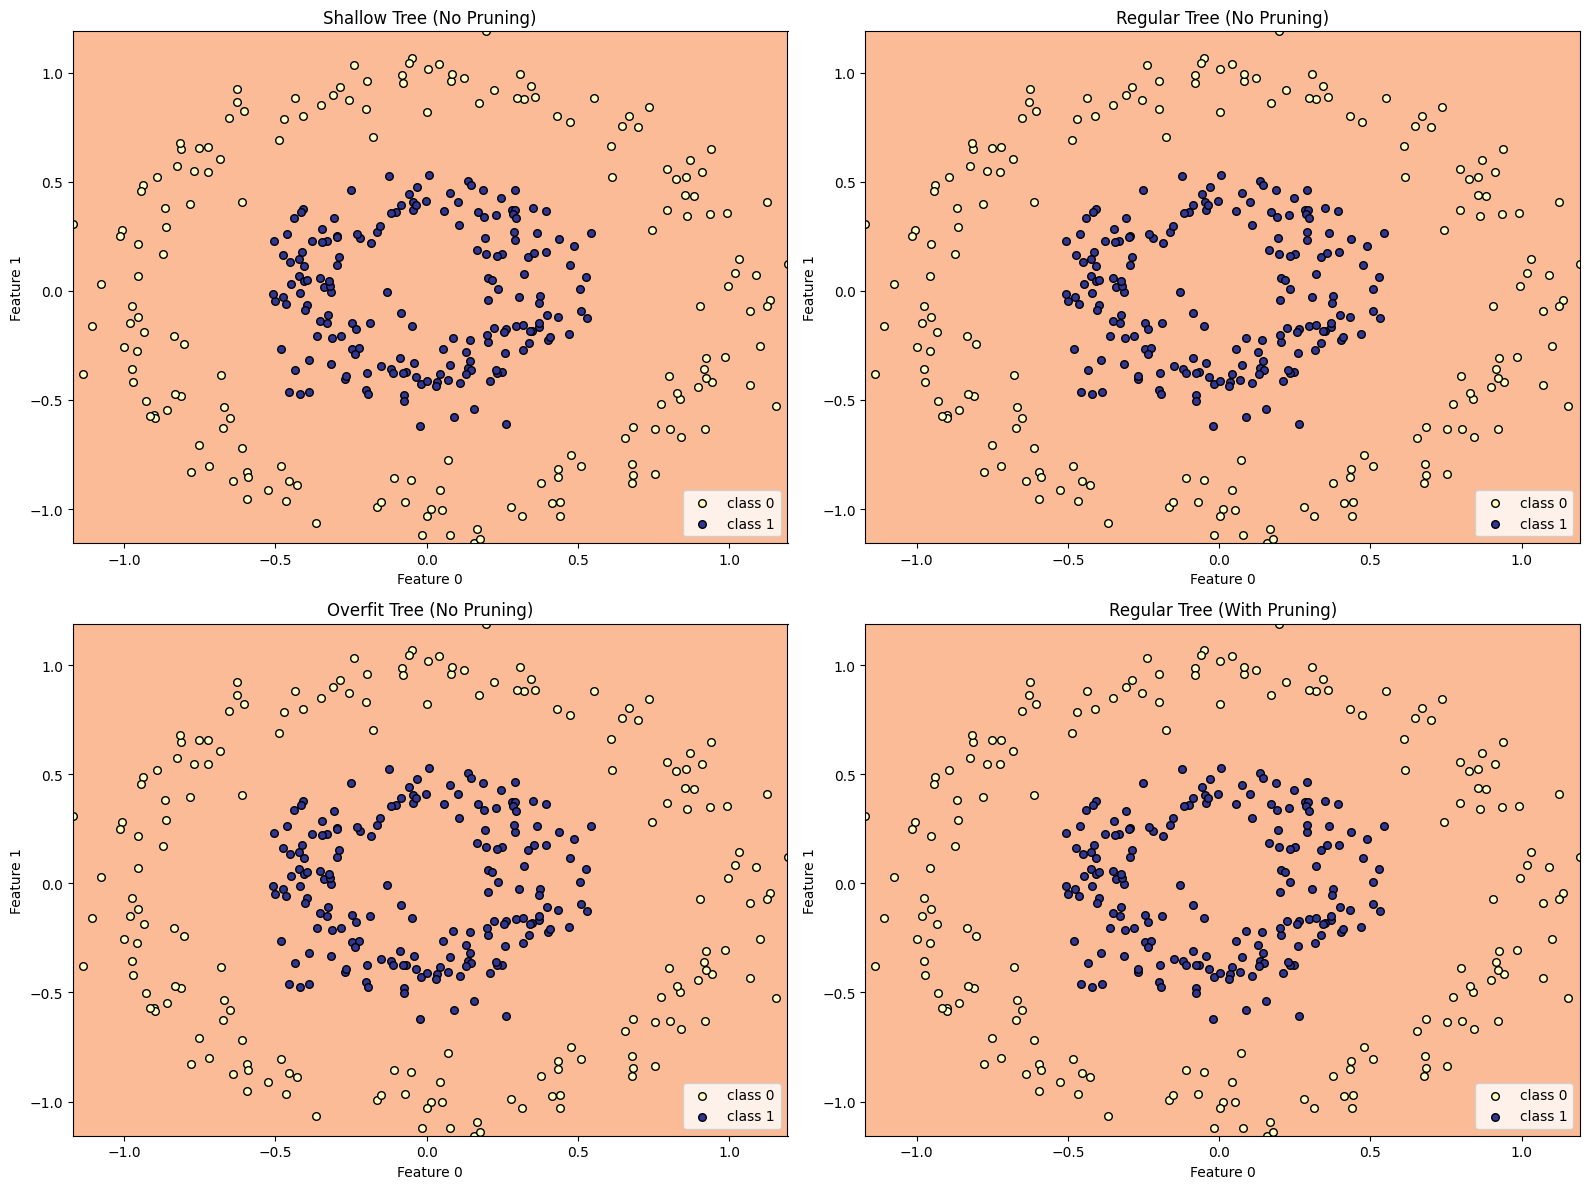

In [32]:
compare_lmt_variants(X_train_ext, X_test_ext, y_train_ext, y_test_ext, lmt)

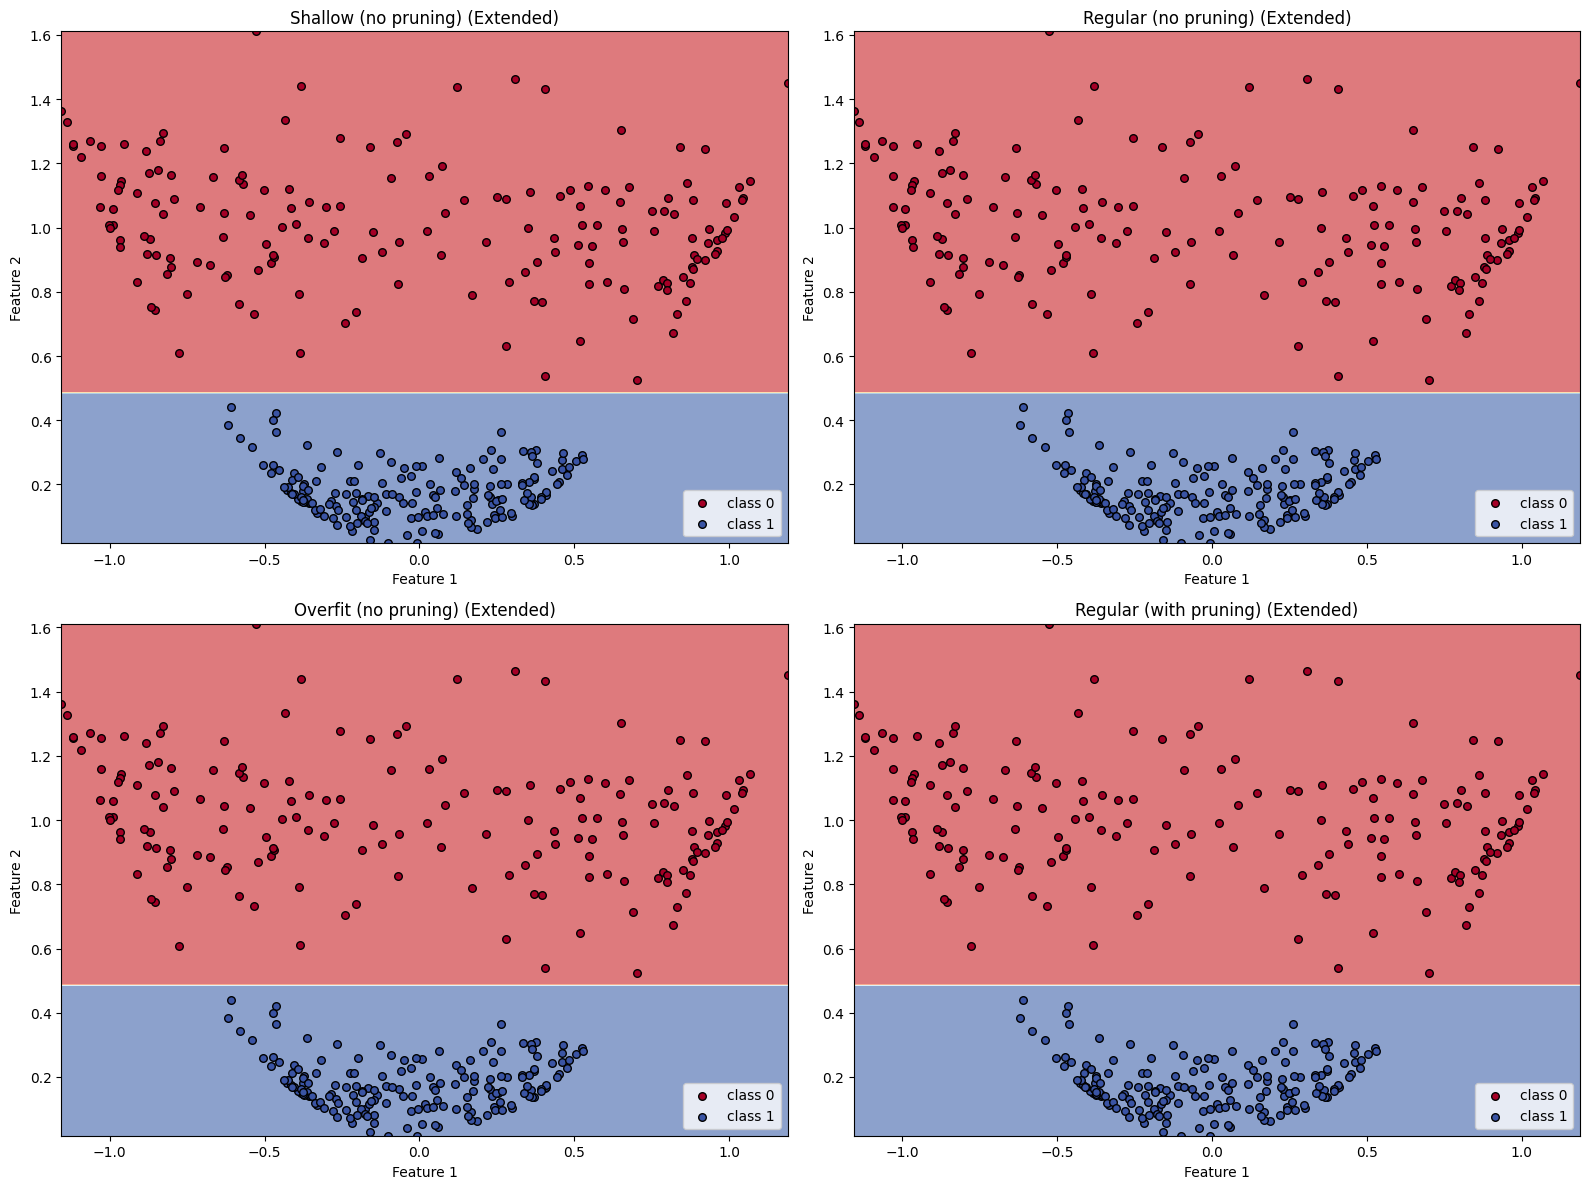

In [34]:
# Plotting decision surfaces of all four trees
clf_shallow_ext, nodes_shallow_ext = lmt.fit_logistic_model_tree(X_train_ext, y_train_ext, size='shallow', pruning=False)
clf_regular_ext, nodes_regular_ext = lmt.fit_logistic_model_tree(X_train_ext, y_train_ext, size='regular', pruning=False)
clf_overfit_ext, nodes_overfit_ext = lmt.fit_logistic_model_tree(X_train_ext, y_train_ext, size='overfit', pruning=False)
clf_pruned_ext, nodes_pruned_ext = lmt.fit_logistic_model_tree(X_train_ext, y_train_ext, size='regular', pruning=True)


clfs_ext   = [clf_shallow_ext,     clf_regular_ext,     clf_overfit_ext,     clf_pruned_ext]
titles     = [
    "Shallow (no pruning) (Extended)",
    "Regular (no pruning) (Extended)",
    "Overfit (no pruning) (Extended)",
    "Regular (with pruning) (Extended)"
]


fig, axes = plt.subplots(2, 2, figsize=(16, 12))
for ax, clf, title in zip(axes.ravel(), clfs_ext, titles):
    lmt.plot_decision_surface_from_fitted_tree(
        clf_tree=clf,
        X=X_train_ext,
        feature_pair=(1, 2),  # adjust if you want different feature axes
        y=y_train_ext,
        fixed_vals=None,
        grid_steps=200,
        cmap='RdYlBu',
        ax=ax,
        title=title
    )

plt.tight_layout()
plt.show()


### Calibration

In [35]:
clf_shallow, nodes_shallow     = lmt.fit_logistic_model_tree(X_train,     y_train,     size='shallow', pruning=False)
clf_regular, nodes_regular     = lmt.fit_logistic_model_tree(X_train,     y_train,     size='regular', pruning=False)
clf_overfit, nodes_overfit     = lmt.fit_logistic_model_tree(X_train,     y_train,     size='overfit', pruning=False)
clf_pruned, nodes_pruned      = lmt.fit_logistic_model_tree(X_train,     y_train,     size='regular', pruning=True)

# clf_shallow_ext, nodes_shallow_ext = lmt.fit_logistic_model_tree(X_train_ext, y_train_ext, size='shallow', pruning=False)
# clf_regular_ext, nodes_regular_ext = lmt.fit_logistic_model_tree(X_train_ext, y_train_ext, size='regular', pruning=False)
# clf_overfit_ext, nodes_overfit_ext = lmt.fit_logistic_model_tree(X_train_ext, y_train_ext, size='overfit', pruning=False)
# clf_pruned_ext, nodes_pruned_ext  = lmt.fit_logistic_model_tree(X_train_ext, y_train_ext, size='regular', pruning=True)

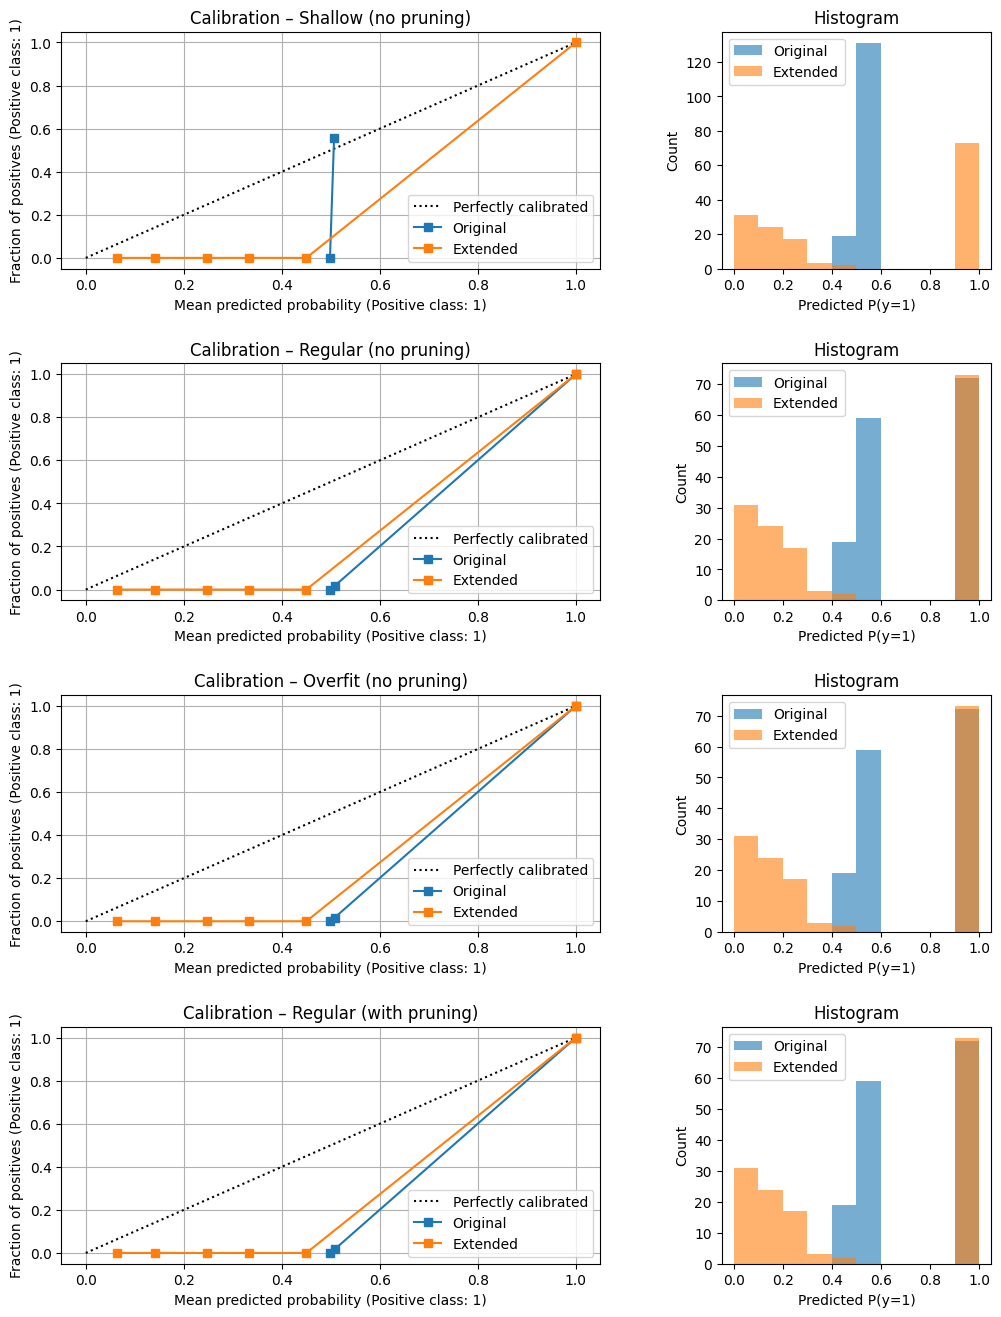

In [36]:
from matplotlib.gridspec import GridSpec

clfs       = [clf_shallow,     clf_regular,     clf_overfit,     clf_pruned]
nodes      = [nodes_shallow,   nodes_regular,   nodes_overfit,   nodes_pruned]
clfs_ext   = [clf_shallow_ext, clf_regular_ext, clf_overfit_ext, clf_pruned_ext]
nodes_ext  = [nodes_shallow_ext, nodes_regular_ext, nodes_overfit_ext, nodes_pruned_ext]
titles     = [
    "Shallow (no pruning)",
    "Regular (no pruning)",
    "Overfit (no pruning)",
    "Regular (with pruning)"
]

fig = plt.figure(figsize=(12, 16))
gs  = GridSpec(4, 2, width_ratios=[2,1], hspace=0.4, wspace=0.3)

for i, title in enumerate(titles):
    ax_curve = fig.add_subplot(gs[i, 0])
    ax_hist  = fig.add_subplot(gs[i, 1])

    # original
    p_orig = lmt.predict_proba_lmt(X_test,     clfs[i],     nodes[i])
    # extended
    p_ext  = lmt.predict_proba_lmt(X_test_ext, clfs_ext[i], nodes_ext[i])

    CalibrationDisplay.from_predictions(y_test,    p_orig, n_bins=10,
                                        name="Original", ax=ax_curve)
    CalibrationDisplay.from_predictions(y_test_ext,p_ext,  n_bins=10,
                                        name="Extended", ax=ax_curve)
    ax_curve.set_title(f"Calibration – {title}")
    ax_curve.grid(True)

    ax_hist.hist(p_orig, bins=10, range=(0,1), alpha=0.6, label="Original")
    ax_hist.hist(p_ext,  bins=10, range=(0,1), alpha=0.6, label="Extended")
    ax_hist.set_title("Histogram")
    ax_hist.set_xlabel("Predicted P(y=1)")
    ax_hist.set_ylabel("Count")
    ax_hist.legend()

plt.show()


In [38]:
from collections import defaultdict
from sklearn.metrics import (
    brier_score_loss,
    log_loss,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score
)

# 1) Assemble your models into one list of (name, clf_tree, node_models, X_te, y_te)
labels = [
    "Shallow tree - No pruning",
    "Regular tree - No pruning",
    "Overfit tree - No pruning",
    "Regular tree - With pruning"
]

orig_models = [
    (f"{label} (original)", clf,   nodes,   X_test,     y_test)
    for label, clf, nodes in zip(
        labels,
        [clf_shallow, clf_regular, clf_overfit, clf_pruned],
        [nodes_shallow, nodes_regular, nodes_overfit, nodes_pruned]
    )
]

ext_models = [
    (f"{label} (extended)", clf,   nodes,   X_test_ext, y_test_ext)
    for label, clf, nodes in zip(
        labels,
        [clf_shallow_ext, clf_regular_ext, clf_overfit_ext, clf_pruned_ext],
        [nodes_shallow_ext, nodes_regular_ext, nodes_overfit_ext, nodes_pruned_ext]
    )
]

all_models = orig_models + ext_models

# 2) Compute metrics
scores = defaultdict(list)

for name, clf_tree, node_models, X_te, y_te in all_models:
    # leaf‐wise probabilities & predictions
    y_prob = lmt.predict_proba_lmt(X_te, clf_tree, node_models)
    y_pred = lmt.predict_lmt(     X_te, clf_tree, node_models)

    scores["Classifier"].append(name)

    # probabilistic metrics
    for metric in (brier_score_loss, log_loss, roc_auc_score):
        col = (
            metric.__name__
                  .replace("_", " ")
                  .replace("score", "")
                  .capitalize()
        )
        scores[col].append(metric(y_te, y_prob))

    # discrete‐prediction metrics
    for metric in (precision_score, recall_score, f1_score):
        col = (
            metric.__name__
                  .replace("_", " ")
                  .replace("score", "")
                  .capitalize()
        )
        scores[col].append(metric(y_te, y_pred))

# 3) Build DataFrame
tree_score_df = (
    pd.DataFrame(scores)
      .set_index("Classifier")
      .round(4)
)

print(tree_score_df)


                                        Brier  loss  Log loss  Roc auc   \
Classifier                                                                
Shallow tree - No pruning (original)         0.2502    0.6935    0.5111   
Regular tree - No pruning (original)         0.1329    0.3662    0.9909   
Overfit tree - No pruning (original)         0.1329    0.3662    0.9909   
Regular tree - With pruning (original)       0.1329    0.3662    0.9909   
Shallow tree - No pruning (extended)         0.0162    0.0865    1.0000   
Regular tree - No pruning (extended)         0.0162    0.0865    1.0000   
Overfit tree - No pruning (extended)         0.0162    0.0865    1.0000   
Regular tree - With pruning (extended)       0.0162    0.0865    1.0000   

                                        Precision   Recall      F1   
Classifier                                                           
Shallow tree - No pruning (original)        0.5573      1.0  0.7157  
Regular tree - No pruning (original)   

## LMT implementation version with *SimpleLogistic* routine just at the root node

### For the original dataset

In [39]:
def compare_lmt_variants_v2(X_train, X_test, y_train, y_test, lmt):
    """
    Trains and evaluates four logistic model trees using different sizes and pruning strategies.
    Plots the tree structure and prints evaluation metrics.
    
    Parameters
    ----------
    X_train, X_test : pd.DataFrame or np.ndarray
        Training and test feature sets.
    y_train, y_test : pd.Series or np.ndarray
        Training and test labels.
    lmt : module or object
        Module or object that provides the `construct_tree` method.
    """
    
    configs = [
        ('shallow', False, "Shallow Tree (No Pruning)"),
        ('regular', False, "Regular Tree (No Pruning)"),
        ('overfit', False, "Overfit Tree (No Pruning)"),
        ('regular', True,  "Regular Tree (With Pruning)")
    ]

    fitted = []

    # Tree construction
    for size, pruning, label in configs:
        clf_tree, node_models = lmt.fit_logistic_model_tree_v2(X_train, y_train, size=size, pruning=pruning)
        #print(node_models)
        # Hard predictions
        y_pred = lmt.predict_lmt(X_test, clf_tree, node_models)
        # 3) extract per‐sample proba. of class 1
        y_prob = lmt.predict_proba_lmt(X_test, clf_tree, node_models)

        # 4) metrics
        acc  = accuracy_score(y_test, y_pred)
        auc  = roc_auc_score(y_test, y_prob)
        loss = log_loss(y_test, y_prob)
        print(f"{label} → Accuracy: {acc:.4f}, AUC: {auc:.4f}, Log Loss: {loss:.4f}")
        
        fitted.append((clf_tree, node_models, label))

    # Plotting all four trees
    for clf_tree, node_models, label in fitted:
        plt.figure(figsize=(16, 8))
        lmt.plot_tree_with_linear_models(
            clf_tree, node_models,
            X=X_train,
            title=label
        )
        plt.tight_layout()
        plt.show()

    # Plotting decision surfaces of all four trees
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    for ax, (clf_tree, _, label) in zip(axes.ravel(), fitted):
        lmt.plot_decision_surface_from_fitted_tree(
            clf_tree=clf_tree,
            X=X_train,
            feature_pair=(0, 1),
            y=y_train,
            fixed_vals=None,
            grid_steps=200,
            cmap='RdYlBu',
            ax=ax,
            title=label
        )
    plt.tight_layout()
    plt.show()



Shallow Tree (No Pruning) → Accuracy: 0.7067, AUC: 0.8175, Log Loss: 0.5110
Regular Tree (No Pruning) → Accuracy: 0.9933, AUC: 0.9929, Log Loss: 0.2276
Overfit Tree (No Pruning) → Accuracy: 0.9933, AUC: 0.9929, Log Loss: 0.2276
Regular Tree (With Pruning) → Accuracy: 0.9933, AUC: 0.9929, Log Loss: 0.2276


<Figure size 1600x800 with 0 Axes>

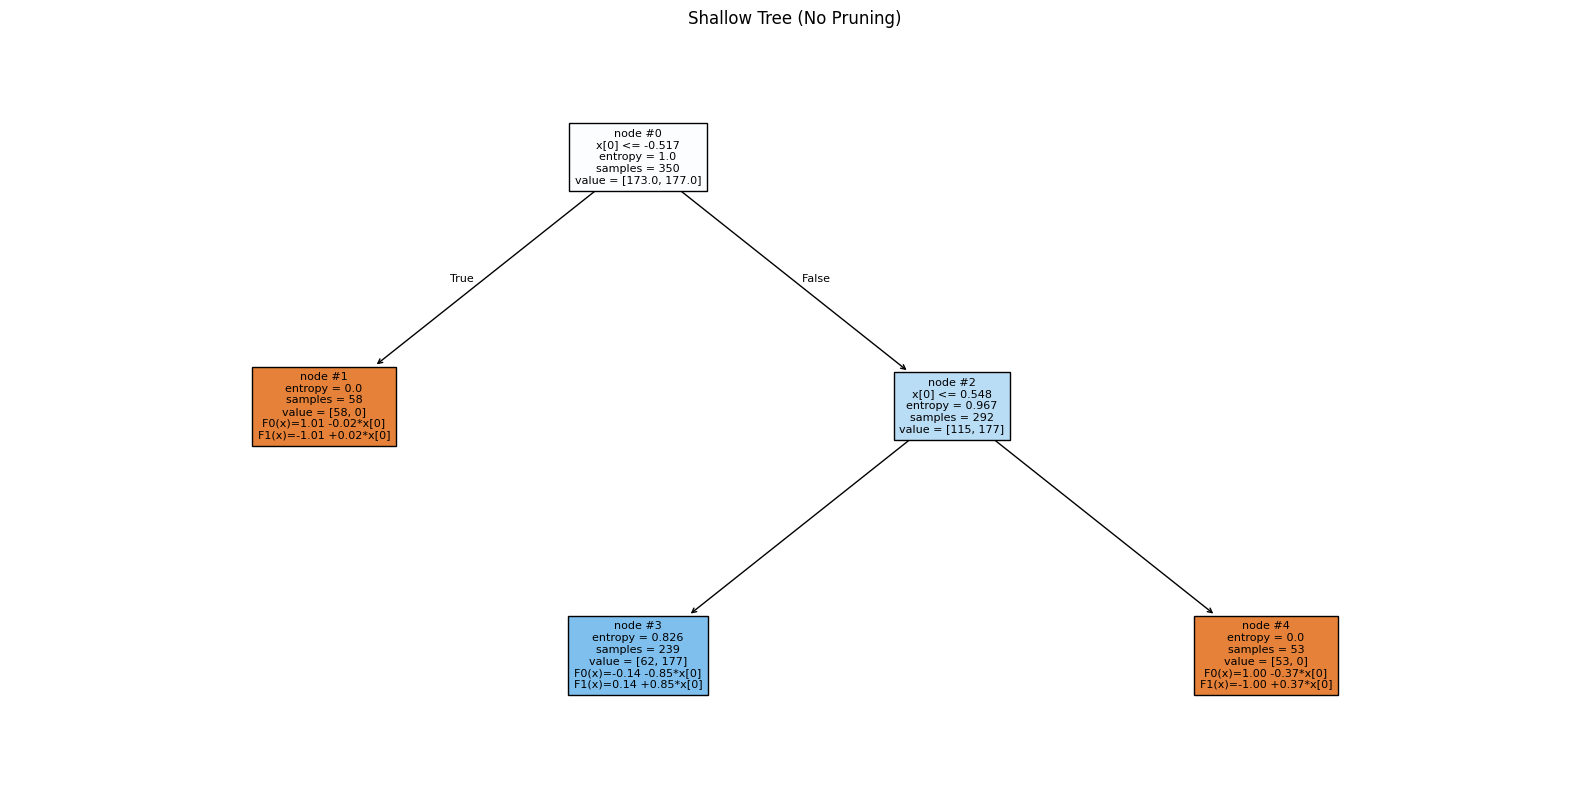

<Figure size 640x480 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

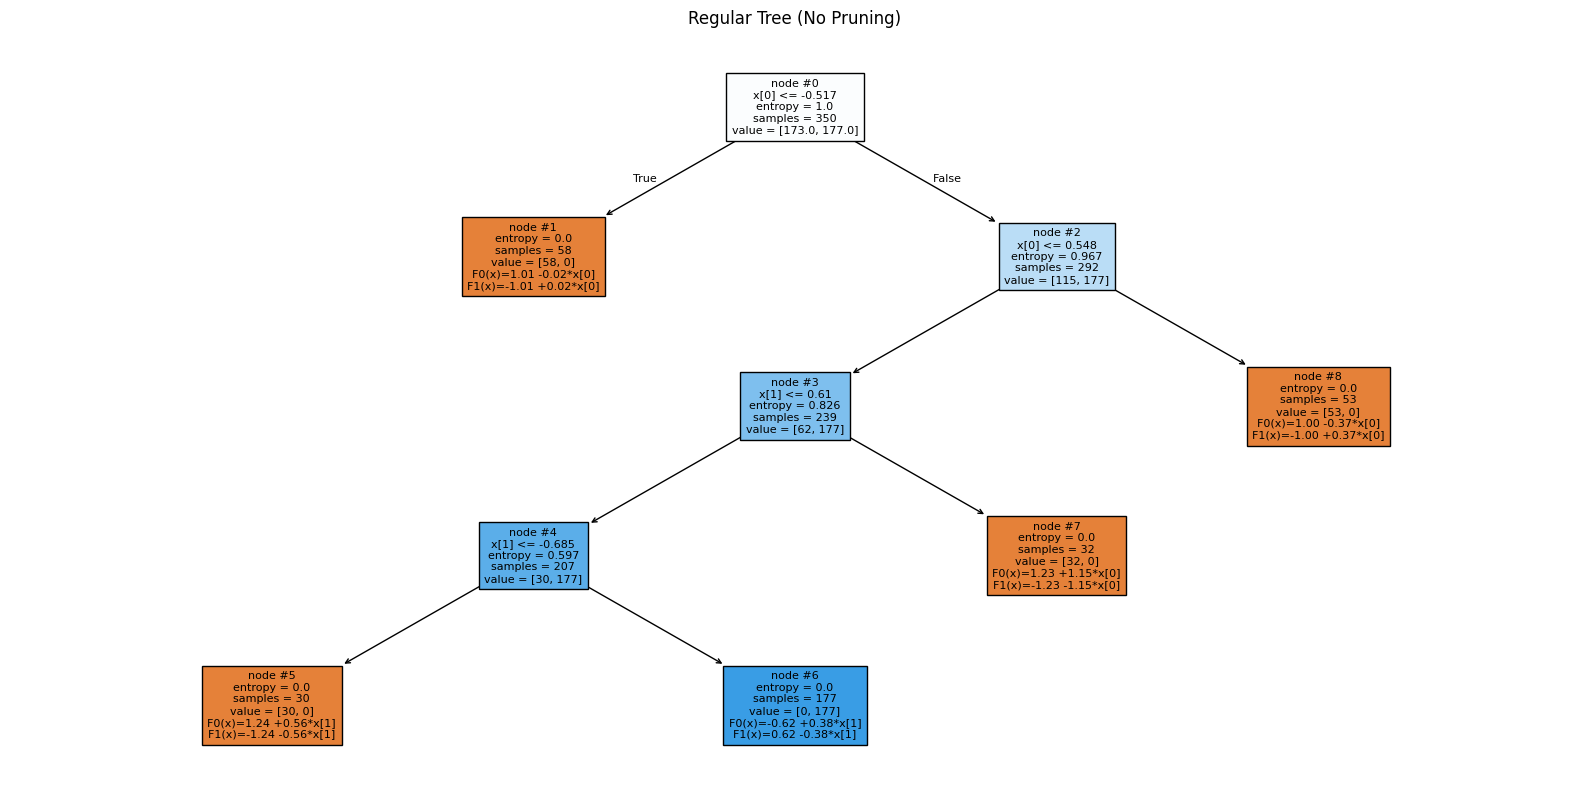

<Figure size 640x480 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

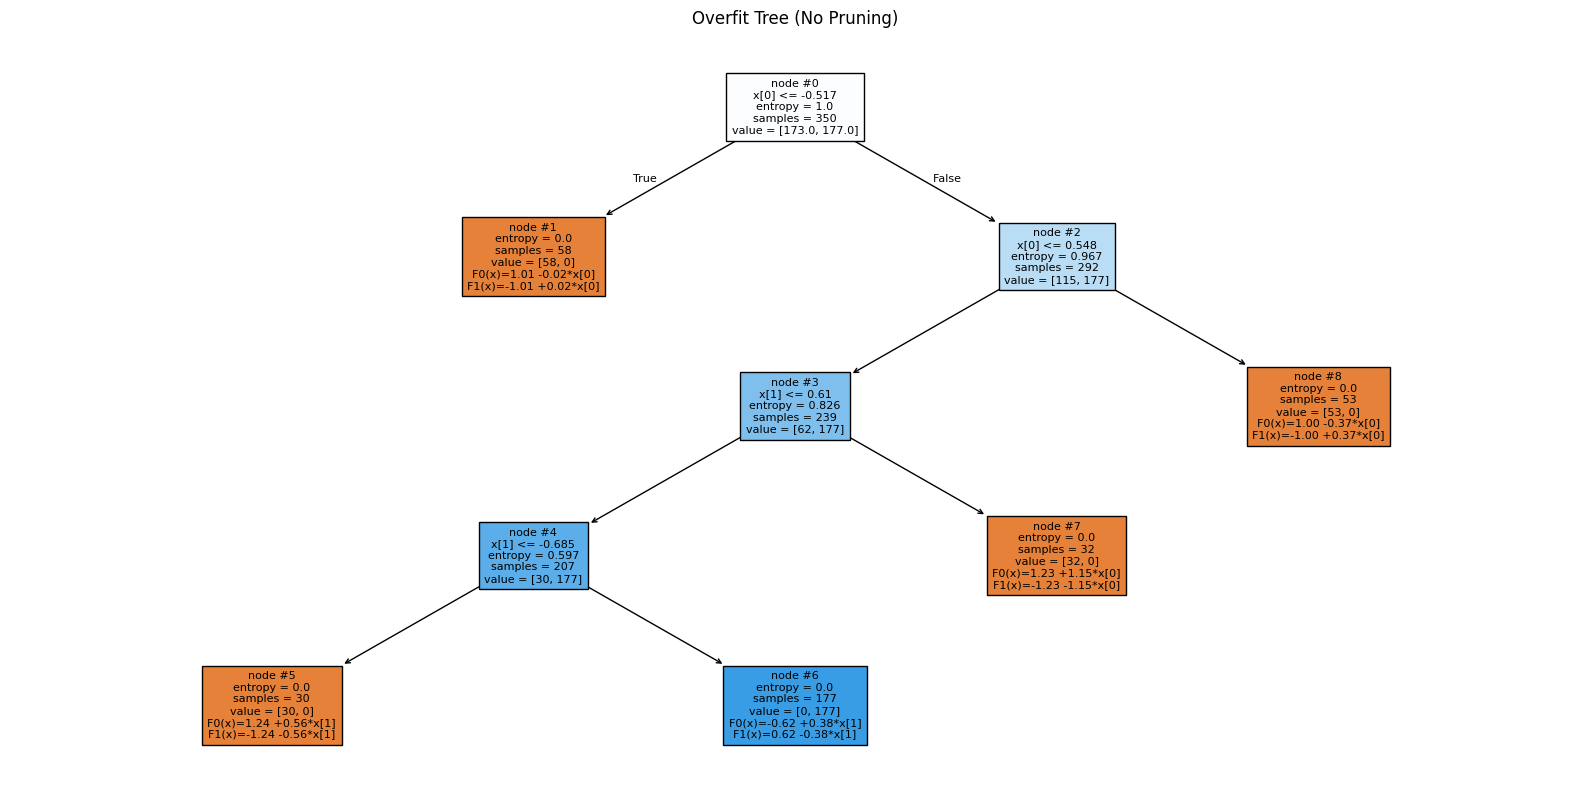

<Figure size 640x480 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

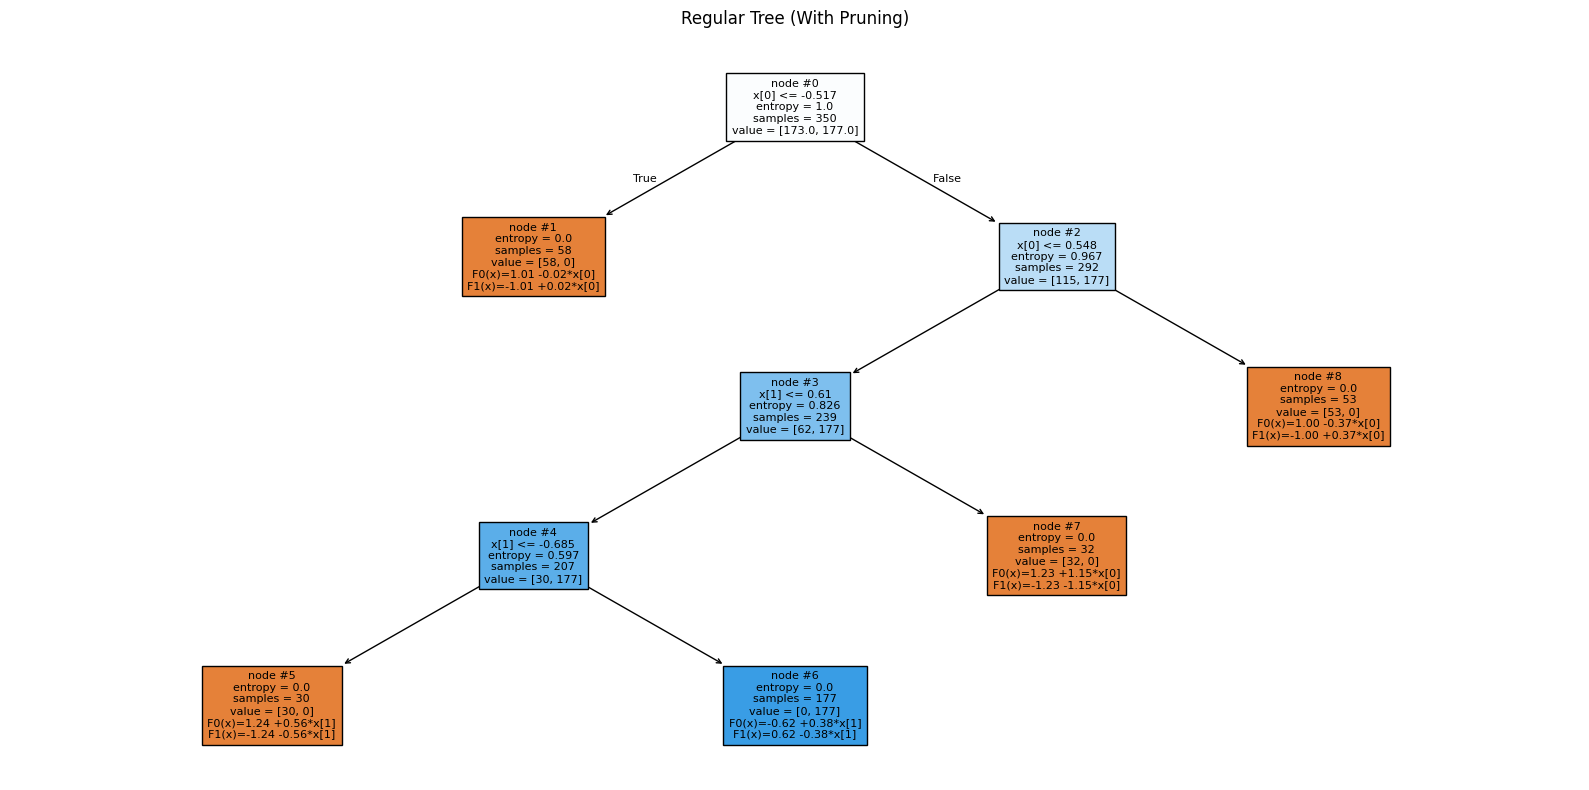

<Figure size 640x480 with 0 Axes>

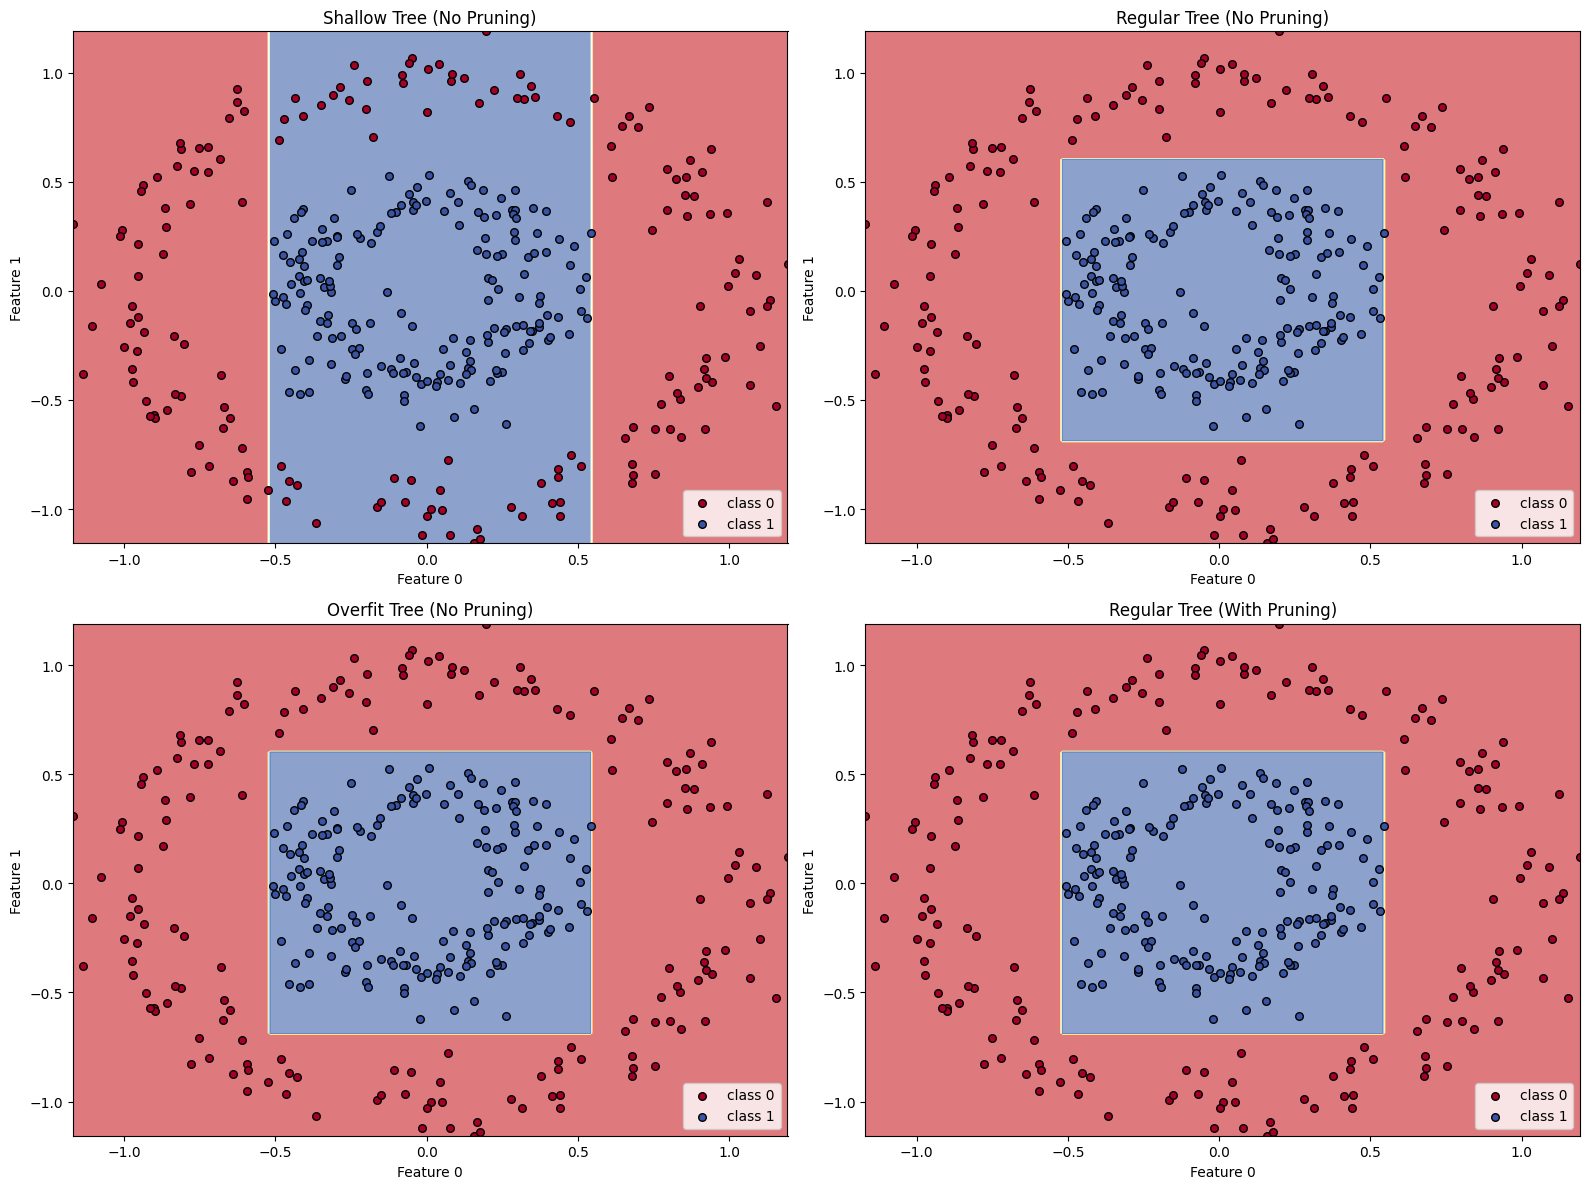

In [40]:
compare_lmt_variants_v2(X_train, X_test, y_train, y_test, lmt)

### For the extended dataset

Shallow Tree (No Pruning) → Accuracy: 1.0000, AUC: 1.0000, Log Loss: 0.0066
Regular Tree (No Pruning) → Accuracy: 1.0000, AUC: 1.0000, Log Loss: 0.0066
Overfit Tree (No Pruning) → Accuracy: 1.0000, AUC: 1.0000, Log Loss: 0.0066
Regular Tree (With Pruning) → Accuracy: 1.0000, AUC: 1.0000, Log Loss: 0.0066


<Figure size 1600x800 with 0 Axes>

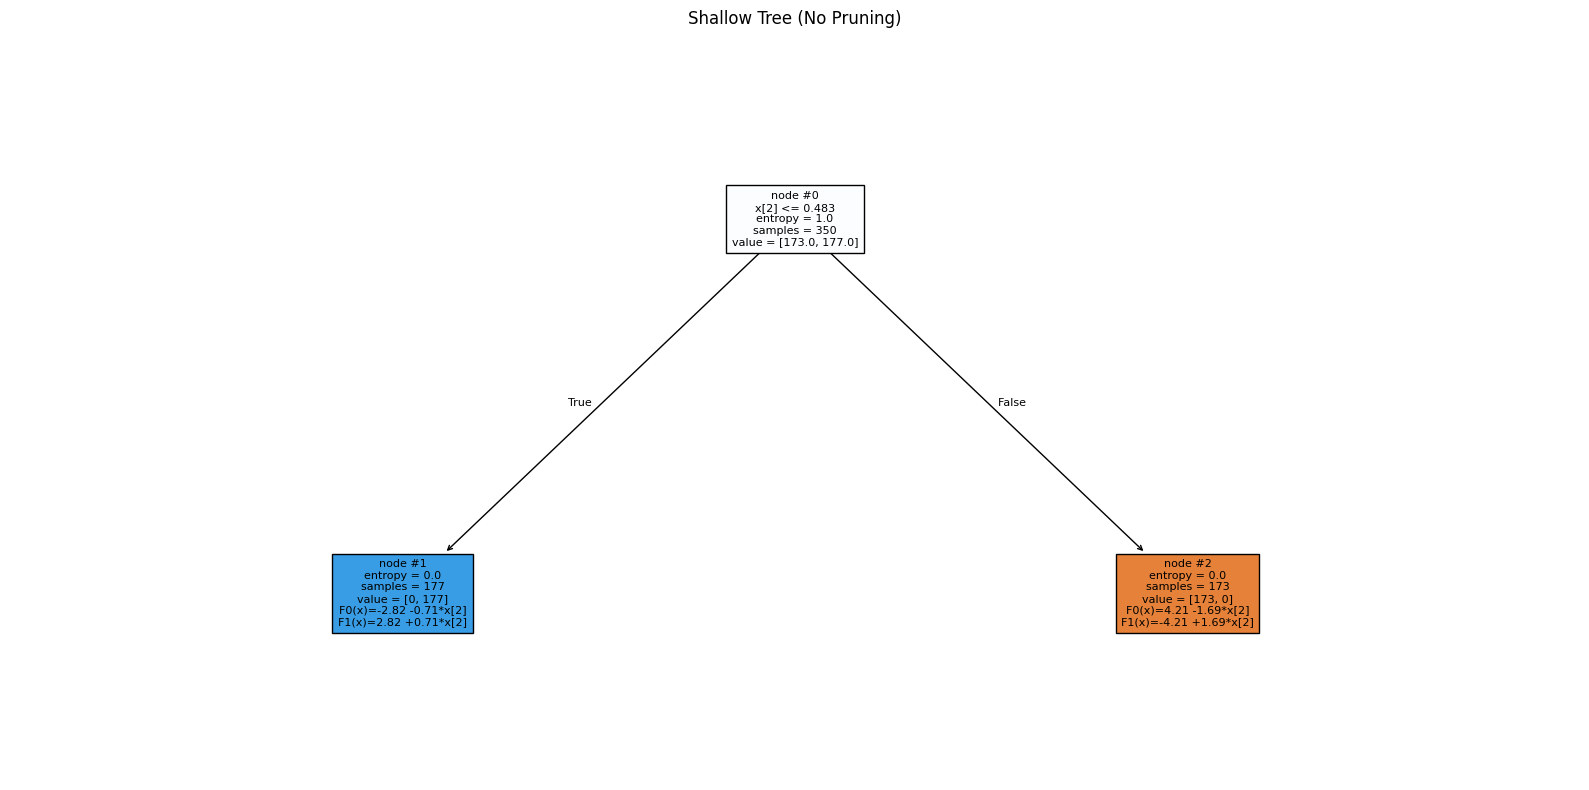

<Figure size 640x480 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

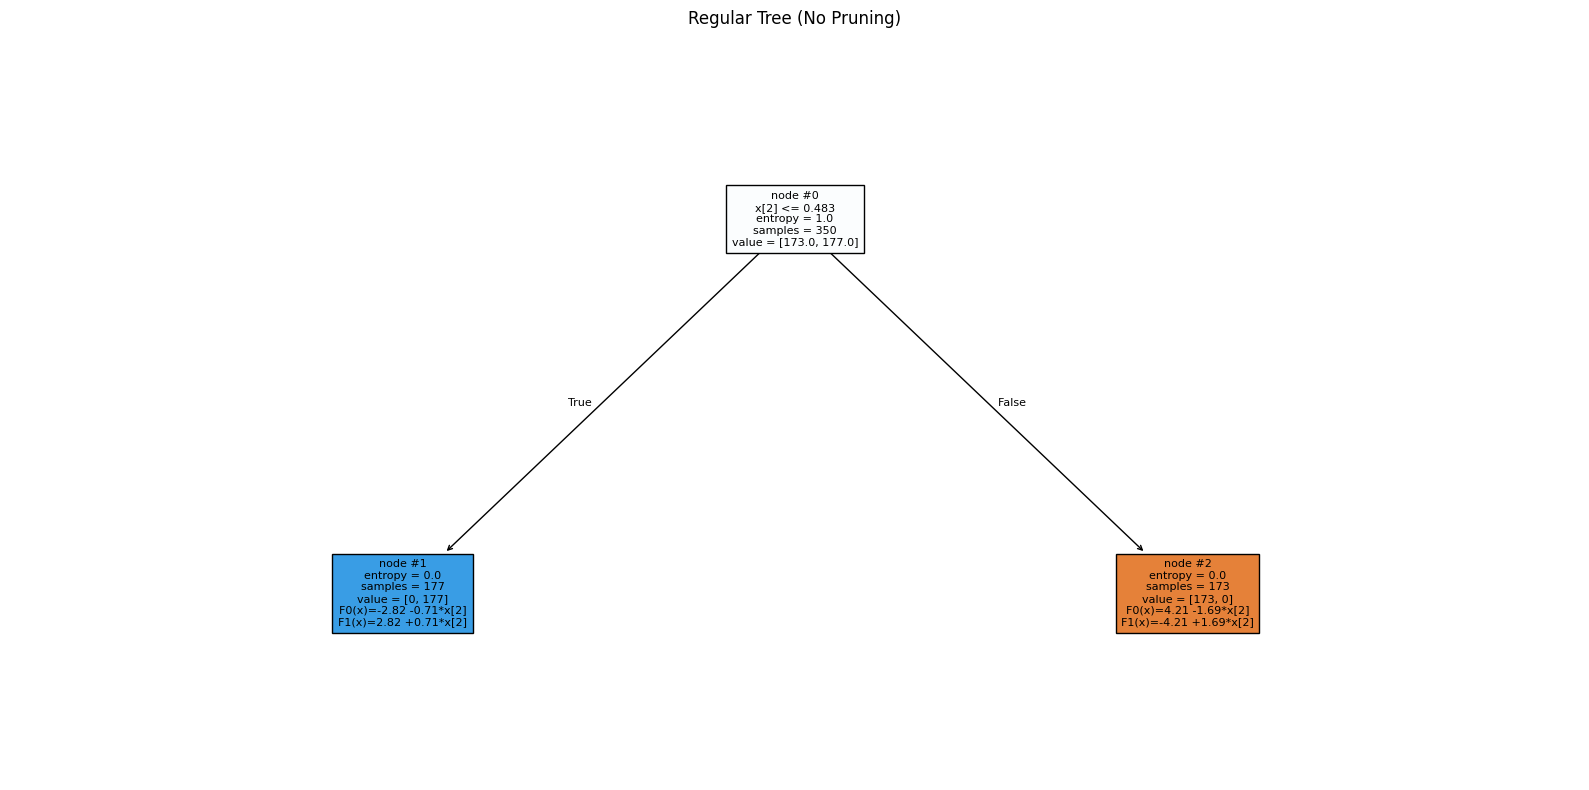

<Figure size 640x480 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

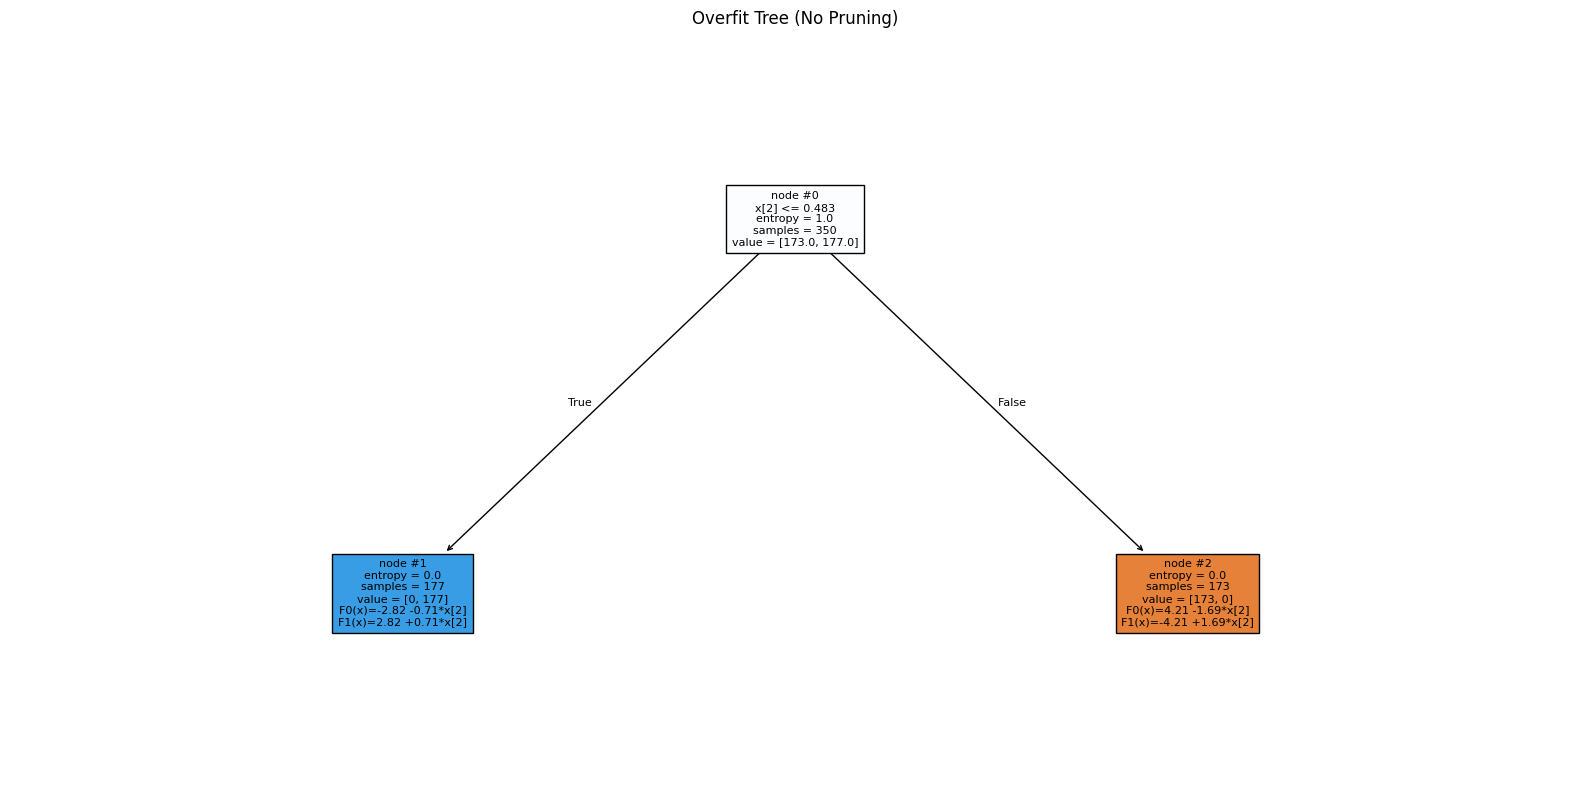

<Figure size 640x480 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

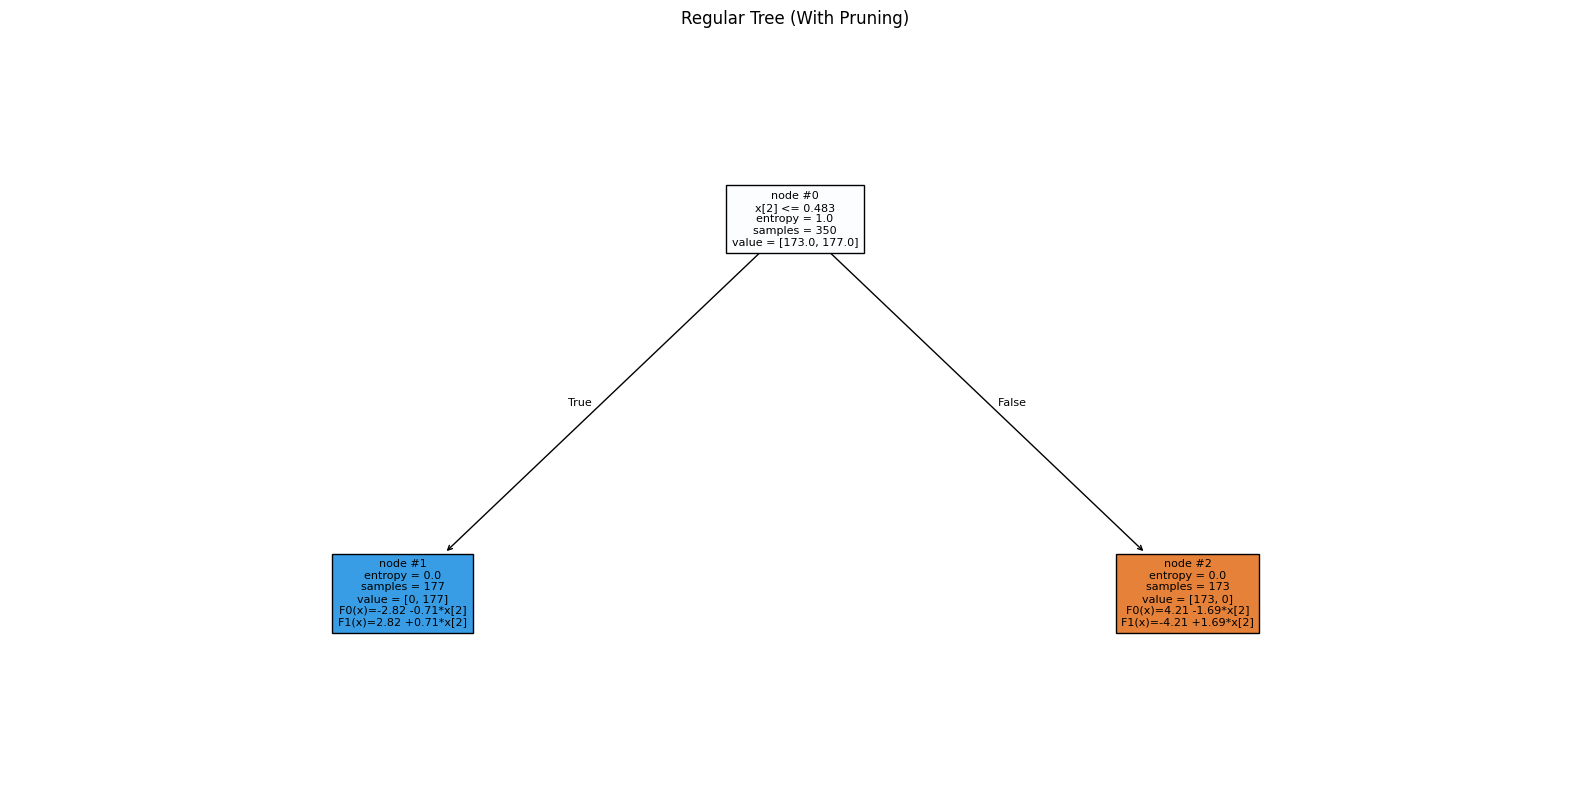

<Figure size 640x480 with 0 Axes>

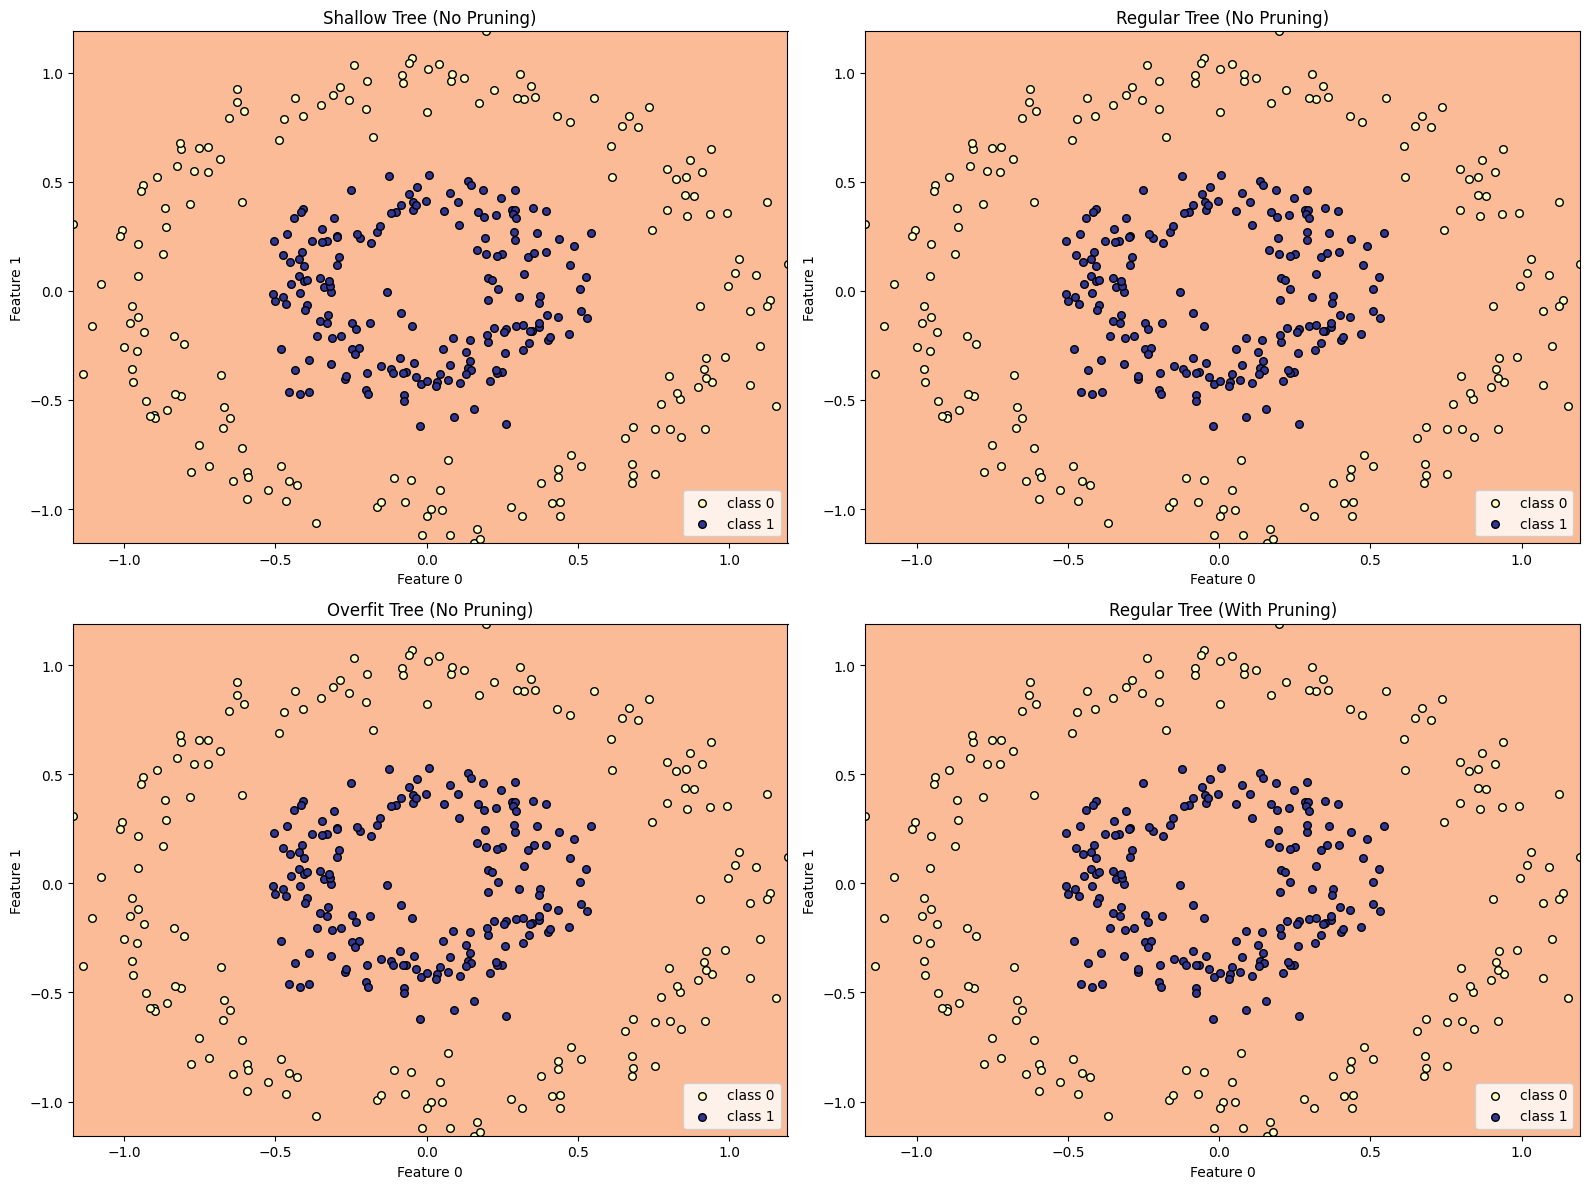

In [41]:
compare_lmt_variants_v2(X_train_ext, X_test_ext, y_train_ext, y_test_ext, lmt)

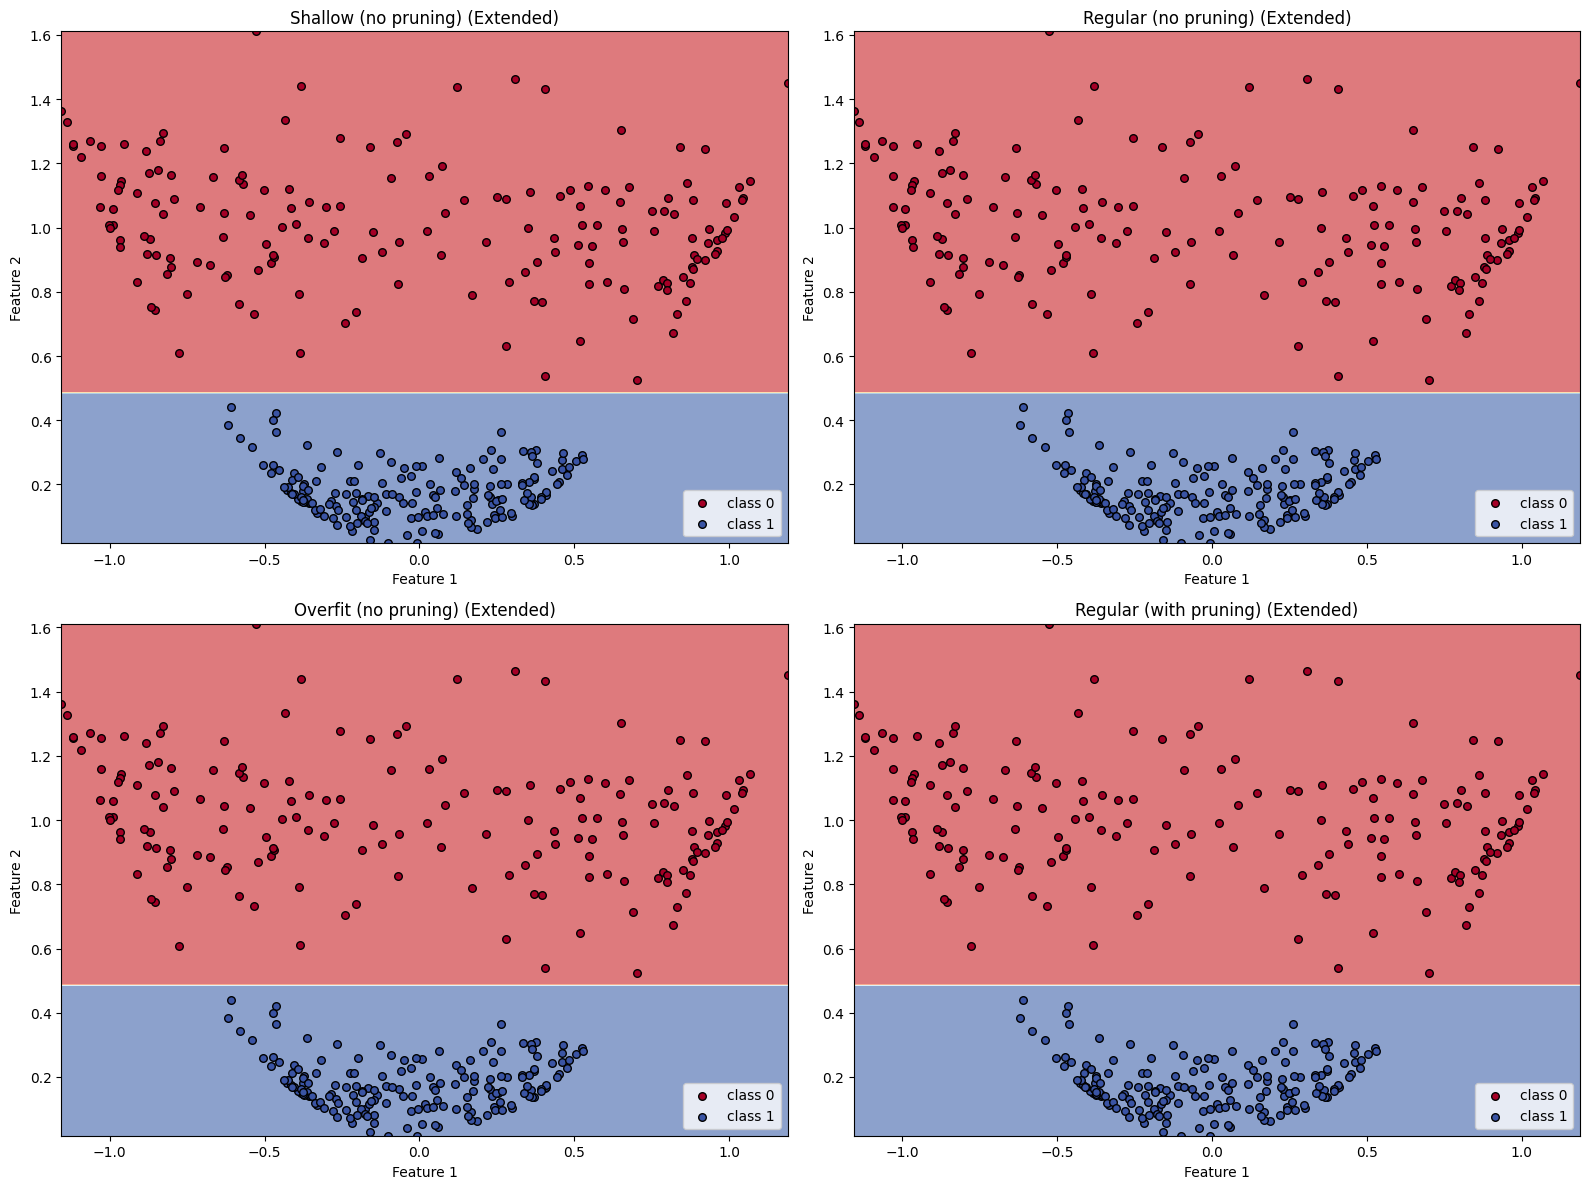

In [42]:
# Plotting decision surfaces of all four trees
clf_shallow_ext, nodes_shallow_ext = lmt.fit_logistic_model_tree_v2(X_train_ext, y_train_ext, size='shallow', pruning=False)
clf_regular_ext, nodes_regular_ext = lmt.fit_logistic_model_tree_v2(X_train_ext, y_train_ext, size='regular', pruning=False)
clf_overfit_ext, nodes_overfit_ext = lmt.fit_logistic_model_tree_v2(X_train_ext, y_train_ext, size='overfit', pruning=False)
clf_pruned_ext, nodes_pruned_ext = lmt.fit_logistic_model_tree_v2(X_train_ext, y_train_ext, size='regular', pruning=True)


clfs_ext   = [clf_shallow_ext,     clf_regular_ext,     clf_overfit_ext,     clf_pruned_ext]
titles     = [
    "Shallow (no pruning) (Extended)",
    "Regular (no pruning) (Extended)",
    "Overfit (no pruning) (Extended)",
    "Regular (with pruning) (Extended)"
]


fig, axes = plt.subplots(2, 2, figsize=(16, 12))
for ax, clf, title in zip(axes.ravel(), clfs_ext, titles):
    lmt.plot_decision_surface_from_fitted_tree(
        clf_tree=clf,
        X=X_train_ext,
        feature_pair=(1, 2),  # adjust if you want different feature axes
        y=y_train_ext,
        fixed_vals=None,
        grid_steps=200,
        cmap='RdYlBu',
        ax=ax,
        title=title
    )

plt.tight_layout()
plt.show()

### Calibration

In [43]:
clf_shallow, nodes_shallow     = lmt.fit_logistic_model_tree_v2(X_train,     y_train,     size='shallow', pruning=False)
clf_regular, nodes_regular     = lmt.fit_logistic_model_tree_v2(X_train,     y_train,     size='regular', pruning=False)
clf_overfit, nodes_overfit     = lmt.fit_logistic_model_tree_v2(X_train,     y_train,     size='overfit', pruning=False)
clf_pruned, nodes_pruned      = lmt.fit_logistic_model_tree_v2(X_train,     y_train,     size='regular', pruning=True)

# clf_shallow_ext, nodes_shallow_ext = lmt.fit_logistic_model_tree_v2(X_train_ext, y_train_ext, size='shallow', pruning=False)
# clf_regular_ext, nodes_regular_ext = lmt.fit_logistic_model_tree_v2(X_train_ext, y_train_ext, size='regular', pruning=False)
# clf_overfit_ext, nodes_overfit_ext = lmt.fit_logistic_model_tree_v2(X_train_ext, y_train_ext, size='overfit', pruning=False)
# clf_pruned_ext, nodes_pruned_ext  = lmt.fit_logistic_model_tree_v2(X_train_ext, y_train_ext, size='regular', pruning=True)

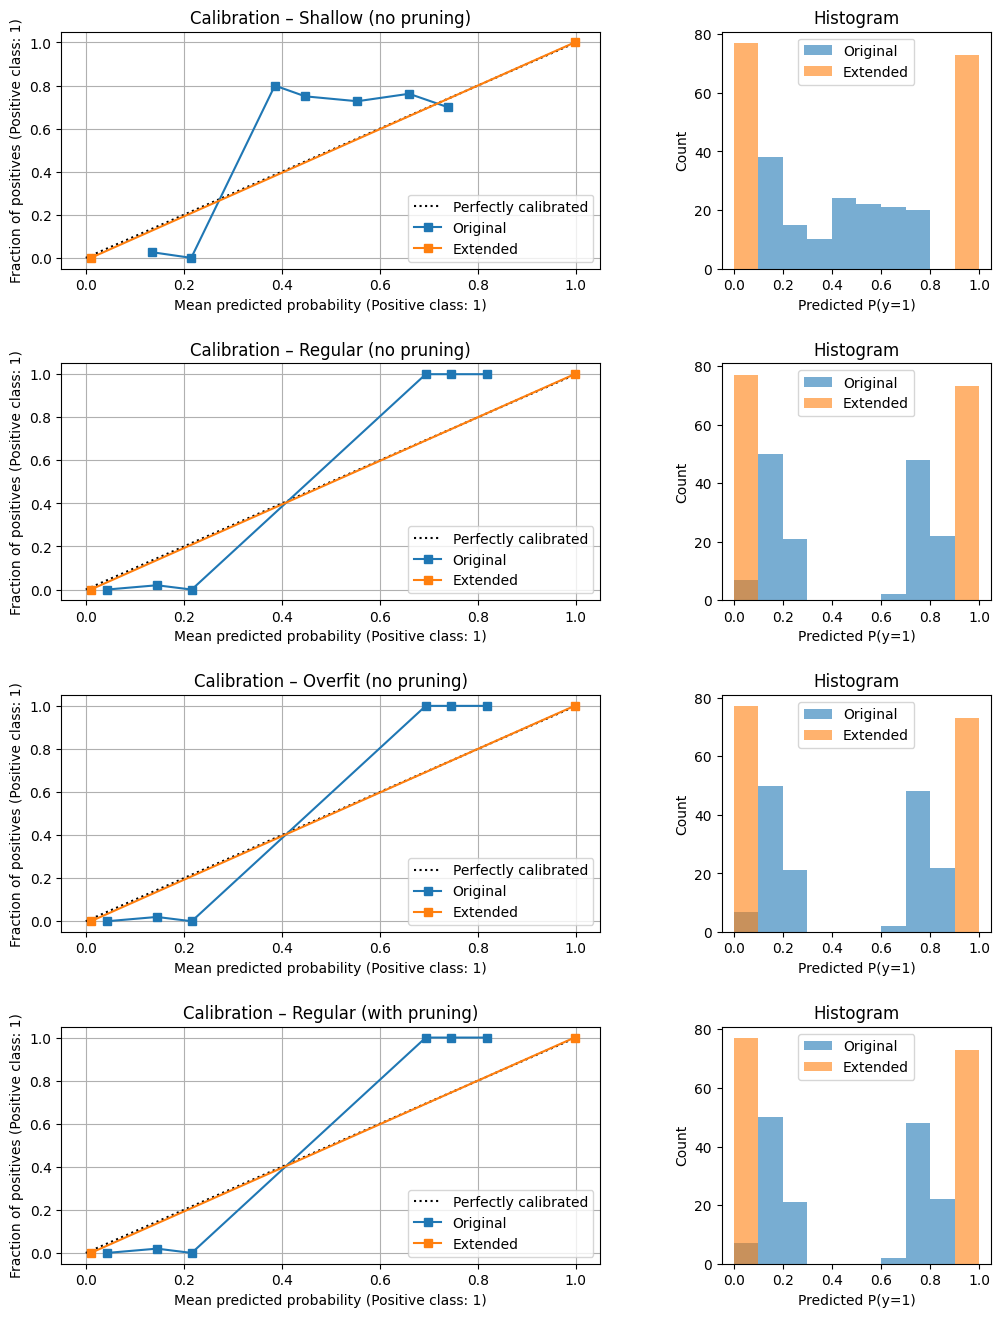

In [44]:
clfs       = [clf_shallow,     clf_regular,     clf_overfit,     clf_pruned]
nodes      = [nodes_shallow,   nodes_regular,   nodes_overfit,   nodes_pruned]
clfs_ext   = [clf_shallow_ext, clf_regular_ext, clf_overfit_ext, clf_pruned_ext]
nodes_ext  = [nodes_shallow_ext, nodes_regular_ext, nodes_overfit_ext, nodes_pruned_ext]
titles     = [
    "Shallow (no pruning)",
    "Regular (no pruning)",
    "Overfit (no pruning)",
    "Regular (with pruning)"
]

fig = plt.figure(figsize=(12, 16))
gs  = GridSpec(4, 2, width_ratios=[2,1], hspace=0.4, wspace=0.3)

for i, title in enumerate(titles):
    ax_curve = fig.add_subplot(gs[i, 0])
    ax_hist  = fig.add_subplot(gs[i, 1])

    # original
    p_orig = lmt.predict_proba_lmt(X_test,     clfs[i],     nodes[i])
    # extended
    p_ext  = lmt.predict_proba_lmt(X_test_ext, clfs_ext[i], nodes_ext[i])

    CalibrationDisplay.from_predictions(y_test,    p_orig, n_bins=10,
                                        name="Original", ax=ax_curve)
    CalibrationDisplay.from_predictions(y_test_ext,p_ext,  n_bins=10,
                                        name="Extended", ax=ax_curve)
    ax_curve.set_title(f"Calibration – {title}")
    ax_curve.grid(True)

    ax_hist.hist(p_orig, bins=10, range=(0,1), alpha=0.6, label="Original")
    ax_hist.hist(p_ext,  bins=10, range=(0,1), alpha=0.6, label="Extended")
    ax_hist.set_title("Histogram")
    ax_hist.set_xlabel("Predicted P(y=1)")
    ax_hist.set_ylabel("Count")
    ax_hist.legend()

plt.show()

In [45]:
# 1) Assemble your models into one list of (name, clf_tree, node_models, X_te, y_te)
labels = [
    "Shallow tree - No pruning",
    "Regular tree - No pruning",
    "Overfit tree - No pruning",
    "Regular tree - With pruning"
]

orig_models = [
    (f"{label} (original)", clf,   nodes,   X_test,     y_test)
    for label, clf, nodes in zip(
        labels,
        [clf_shallow, clf_regular, clf_overfit, clf_pruned],
        [nodes_shallow, nodes_regular, nodes_overfit, nodes_pruned]
    )
]

ext_models = [
    (f"{label} (extended)", clf,   nodes,   X_test_ext, y_test_ext)
    for label, clf, nodes in zip(
        labels,
        [clf_shallow_ext, clf_regular_ext, clf_overfit_ext, clf_pruned_ext],
        [nodes_shallow_ext, nodes_regular_ext, nodes_overfit_ext, nodes_pruned_ext]
    )
]

all_models = orig_models + ext_models

# 2) Compute metrics
scores = defaultdict(list)

for name, clf_tree, node_models, X_te, y_te in all_models:
    # leaf‐wise probabilities & predictions
    y_prob = lmt.predict_proba_lmt(X_te, clf_tree, node_models)
    y_pred = lmt.predict_lmt(     X_te, clf_tree, node_models)

    scores["Classifier"].append(name)

    # probabilistic metrics
    for metric in (brier_score_loss, log_loss, roc_auc_score):
        col = (
            metric.__name__
                  .replace("_", " ")
                  .replace("score", "")
                  .capitalize()
        )
        scores[col].append(metric(y_te, y_prob))

    # discrete‐prediction metrics
    for metric in (precision_score, recall_score, f1_score):
        col = (
            metric.__name__
                  .replace("_", " ")
                  .replace("score", "")
                  .capitalize()
        )
        scores[col].append(metric(y_te, y_pred))

# 3) Build DataFrame
tree_score_df = (
    pd.DataFrame(scores)
      .set_index("Classifier")
      .round(4)
)

print(tree_score_df)

                                        Brier  loss  Log loss  Roc auc   \
Classifier                                                                
Shallow tree - No pruning (original)         0.1712    0.5110    0.8175   
Regular tree - No pruning (original)         0.0455    0.2276    0.9929   
Overfit tree - No pruning (original)         0.0455    0.2276    0.9929   
Regular tree - With pruning (original)       0.0455    0.2276    0.9929   
Shallow tree - No pruning (extended)         0.0001    0.0066    1.0000   
Regular tree - No pruning (extended)         0.0001    0.0066    1.0000   
Overfit tree - No pruning (extended)         0.0001    0.0066    1.0000   
Regular tree - With pruning (extended)       0.0001    0.0066    1.0000   

                                        Precision   Recall      F1   
Classifier                                                           
Shallow tree - No pruning (original)        0.7302   0.6301  0.6765  
Regular tree - No pruning (original)   